# Road surface detection and differentiation considering surface damages

## 1. Initial settings

---



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version

Fri Jul 30 03:27:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install fastai==2.3.0
!pip3 install gputil
!pip install yacs

     |████████████████████████████████| 193 kB 7.6 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 776.8 MB 16 kB/s 
     |████████████████████████████████| 12.8 MB 22 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.1 which is incompati

In [3]:
from fastai.vision.all import *
from fastai.vision.models import resnet18
import GPUtil as GPU

from pathlib import Path
import cv2
from PIL import Image
import warnings
from google.colab import drive
import os
from matplotlib.colors import ListedColormap
import time

In [4]:
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !mkdir /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/
# !mkdir /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/images
# !mkdir /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/pt_labels
# !cp -a /content/drive/Shareddrives/Carro\ Autonomo/Datasets\ Caminho/RTKNet/images/. /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/images
# !cp -a /content/drive/Shareddrives/Carro\ Autonomo/Datasets\ Caminho/RTKNet/labels/. /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/labels
# !cp -a /content/drive/Shareddrives/Carro\ Autonomo/Datasets\ Caminho/RTKNet/pt_labels/. /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/pt_labels

In [ ]:
# from os import listdir
# from os.path import isfile, join
# files = [f for f in listdir('/content/drive/Shareddrives/Carro Autonomo/Datasets Caminho/RTKNet/labels_clean/') if isfile(join('/content/drive/Shareddrives/Carro Autonomo/Datasets Caminho/RTKNet/labels_clean/', f))]
# for f in files:
#   number = int(f[:-4])
#   # print(number)
#   if number >= 732:
#     # print(f)
#     !cp /content/drive/Shareddrives/Carro\ Autonomo/Datasets\ Caminho/RTKNet/'labels_clean/'$f /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/ufsc-1/'labels/'$f
#     # break

##Configs

###HRNET

In [ ]:

# # ------------------------------------------------------------------------------
# # Copyright (c) Microsoft
# # Licensed under the MIT License.
# # Written by Ke Sun (sunk@mail.ustc.edu.cn)
# # ------------------------------------------------------------------------------

# from yacs.config import CfgNode as CN


# _C = CN()

# _C.OUTPUT_DIR = ''
# _C.LOG_DIR = ''
# _C.GPUS = (0,)
# _C.WORKERS = 4
# _C.PRINT_FREQ = 20
# _C.AUTO_RESUME = False
# _C.PIN_MEMORY = True
# _C.RANK = 0

# # Cudnn related params
# _C.CUDNN = CN()
# _C.CUDNN.BENCHMARK = True
# _C.CUDNN.DETERMINISTIC = False
# _C.CUDNN.ENABLED = True

# # common params for NETWORK
# _C.MODEL = CN()
# _C.MODEL.NAME = 'seg_hrnet'
# _C.MODEL.PRETRAINED = ''
# _C.MODEL.ALIGN_CORNERS = True
# _C.MODEL.NUM_OUTPUTS = 1
# _C.MODEL.EXTRA = CN(new_allowed=True)

# _C.MODEL.PRETRAINED_LAYERS = ['*']
# _C.MODEL.STEM_INPLANES = 64
# _C.MODEL.FINAL_CONV_KERNEL = 1
# _C.MODEL.WITH_HEAD = True

# _C.MODEL.STAGE1 = CN()
# _C.MODEL.STAGE1.NUM_MODULES = 1
# _C.MODEL.STAGE1.NUM_BRANCHES = 1
# _C.MODEL.STAGE1.NUM_BLOCKS = [4]
# _C.MODEL.STAGE1.NUM_CHANNELS = [64]
# _C.MODEL.STAGE1.BLOCK = 'BOTTLENECK'
# _C.MODEL.STAGE1.FUSE_METHOD = 'SUM'

# _C.MODEL.STAGE2 = CN()
# _C.MODEL.STAGE2.NUM_MODULES = 1
# _C.MODEL.STAGE2.NUM_BRANCHES = 2
# _C.MODEL.STAGE2.NUM_BLOCKS = [4, 4]
# _C.MODEL.STAGE2.NUM_CHANNELS = [32, 64]
# _C.MODEL.STAGE2.BLOCK = 'BASIC'
# _C.MODEL.STAGE2.FUSE_METHOD = 'SUM'

# _C.MODEL.STAGE3 = CN()
# _C.MODEL.STAGE3.NUM_MODULES = 1
# _C.MODEL.STAGE3.NUM_BRANCHES = 3
# _C.MODEL.STAGE3.NUM_BLOCKS = [4, 4, 4]
# _C.MODEL.STAGE3.NUM_CHANNELS = [32, 64, 128]
# _C.MODEL.STAGE3.BLOCK = 'BASIC'
# _C.MODEL.STAGE3.FUSE_METHOD = 'SUM'

# _C.MODEL.STAGE4 = CN()
# _C.MODEL.STAGE4.NUM_MODULES = 1
# _C.MODEL.STAGE4.NUM_BRANCHES = 4
# _C.MODEL.STAGE4.NUM_BLOCKS = [4, 4, 4, 4]
# _C.MODEL.STAGE4.NUM_CHANNELS = [32, 64, 128, 256]
# _C.MODEL.STAGE4.BLOCK = 'BASIC'
# _C.MODEL.STAGE4.FUSE_METHOD = 'SUM'

# _C.MODEL.OCR = CN()
# _C.MODEL.OCR.MID_CHANNELS = 512
# _C.MODEL.OCR.KEY_CHANNELS = 256
# _C.MODEL.OCR.DROPOUT = 0.05
# _C.MODEL.OCR.SCALE = 1

# _C.LOSS = CN()
# _C.LOSS.USE_OHEM = False
# _C.LOSS.OHEMTHRES = 0.9
# _C.LOSS.OHEMKEEP = 100000
# _C.LOSS.CLASS_BALANCE = False
# _C.LOSS.BALANCE_WEIGHTS = [1]

# # DATASET related params
# _C.DATASET = CN()
# _C.DATASET.ROOT = ''
# _C.DATASET.DATASET = 'cityscapes'
# _C.DATASET.NUM_CLASSES = 13
# _C.DATASET.TRAIN_SET = 'list/cityscapes/train.lst'
# _C.DATASET.EXTRA_TRAIN_SET = ''
# _C.DATASET.TEST_SET = 'list/cityscapes/val.lst'

# # training
# _C.TRAIN = CN()

# _C.TRAIN.FREEZE_LAYERS = ''
# _C.TRAIN.FREEZE_EPOCHS = -1
# _C.TRAIN.NONBACKBONE_KEYWORDS = []
# _C.TRAIN.NONBACKBONE_MULT = 10

# _C.TRAIN.IMAGE_SIZE = [1024, 512]  # width * height
# _C.TRAIN.BASE_SIZE = 2048
# _C.TRAIN.DOWNSAMPLERATE = 1
# _C.TRAIN.FLIP = True
# _C.TRAIN.MULTI_SCALE = True
# _C.TRAIN.SCALE_FACTOR = 16

# _C.TRAIN.RANDOM_BRIGHTNESS = False
# _C.TRAIN.RANDOM_BRIGHTNESS_SHIFT_VALUE = 10

# _C.TRAIN.LR_FACTOR = 0.1
# _C.TRAIN.LR_STEP = [90, 110]
# _C.TRAIN.LR = 0.01
# _C.TRAIN.EXTRA_LR = 0.001

# _C.TRAIN.OPTIMIZER = 'sgd'
# _C.TRAIN.MOMENTUM = 0.9
# _C.TRAIN.WD = 0.0001
# _C.TRAIN.NESTEROV = False
# _C.TRAIN.IGNORE_LABEL = -1

# _C.TRAIN.BEGIN_EPOCH = 0
# _C.TRAIN.END_EPOCH = 484
# _C.TRAIN.EXTRA_EPOCH = 0

# _C.TRAIN.RESUME = False

# _C.TRAIN.BATCH_SIZE_PER_GPU = 32
# _C.TRAIN.SHUFFLE = True
# # only using some training samples
# _C.TRAIN.NUM_SAMPLES = 0

# # testing
# _C.TEST = CN()

# _C.TEST.IMAGE_SIZE = [2048, 1024]  # width * height
# _C.TEST.BASE_SIZE = 2048

# _C.TEST.BATCH_SIZE_PER_GPU = 32
# # only testing some samples
# _C.TEST.NUM_SAMPLES = 0

# _C.TEST.MODEL_FILE = ''
# _C.TEST.FLIP_TEST = False
# _C.TEST.MULTI_SCALE = False
# _C.TEST.SCALE_LIST = [1]

# _C.TEST.OUTPUT_INDEX = -1

# # debug
# _C.DEBUG = CN()
# _C.DEBUG.DEBUG = False
# _C.DEBUG.SAVE_BATCH_IMAGES_GT = False
# _C.DEBUG.SAVE_BATCH_IMAGES_PRED = False
# _C.DEBUG.SAVE_HEATMAPS_GT = False
# _C.DEBUG.SAVE_HEATMAPS_PRED = False


###Lite

In [6]:

# ------------------------------------------------------------------------------
# Copyright (c) Microsoft
# Licensed under the MIT License.
# Written by Ke Sun (sunk@mail.ustc.edu.cn)
# ------------------------------------------------------------------------------

from yacs.config import CfgNode as CN


_C = CN()

_C.OUTPUT_DIR = ''
_C.LOG_DIR = ''
_C.GPUS = (0,)
_C.WORKERS = 4
_C.PRINT_FREQ = 20
_C.AUTO_RESUME = False
_C.PIN_MEMORY = True
_C.RANK = 0

# Cudnn related params
_C.CUDNN = CN()
_C.CUDNN.BENCHMARK = True
_C.CUDNN.DETERMINISTIC = False
_C.CUDNN.ENABLED = True

# common params for NETWORK
_C.MODEL = CN()
_C.MODEL.NAME = 'lite_hrnet'
_C.MODEL.PRETRAINED = ''
_C.MODEL.ALIGN_CORNERS = True
_C.MODEL.NUM_OUTPUTS = 1
_C.MODEL.EXTRA = CN(new_allowed=True)

_C.MODEL.PRETRAINED_LAYERS = ['*']
_C.MODEL.STEM_INPLANES = 64


_C.MODEL.EXTRA.FINAL_CONV_KERNEL = 1
_C.MODEL.EXTRA.num_stages = 3

_C.MODEL.EXTRA.stem = CN(new_allowed=True)
_C.MODEL.EXTRA.stem.stem_channels = 32
_C.MODEL.EXTRA.stem.out_channels = 32
_C.MODEL.EXTRA.stem.expand_ratio = 1

_C.MODEL.EXTRA.stages_spec = CN(new_allowed=True)
_C.MODEL.EXTRA.stages_spec.num_modules = (2, 4, 2)
_C.MODEL.EXTRA.stages_spec.num_branches = (2, 3, 4)
_C.MODEL.EXTRA.stages_spec.num_blocks = (2, 2, 2)
_C.MODEL.EXTRA.stages_spec.module_type=('LITE', 'LITE', 'LITE')
_C.MODEL.EXTRA.stages_spec.with_fuse=(True, True, True)
_C.MODEL.EXTRA.stages_spec.reduce_ratios=(8, 8, 8)
_C.MODEL.EXTRA.stages_spec.num_channels=(
                    (40, 80),
                    (40, 80, 160),
                    (40, 80, 160, 320),
                )
_C.MODEL.EXTRA.stages_spec.module_type=('LITE', 'LITE', 'LITE')
_C.MODEL.EXTRA.with_head = False

# extra=dict(
#             stem=dict(stem_channels=32, out_channels=32, expand_ratio=1),
#             num_stages=3,
#             stages_spec=dict(
#                 num_modules=(2, 4, 2),
#                 num_branches=(2, 3, 4),
#                 num_blocks=(2, 2, 2),
#                 module_type=('LITE', 'LITE', 'LITE'),
#                 with_fuse=(True, True, True),
#                 reduce_ratios=(8, 8, 8),
#                 num_channels=(
#                     (40, 80),
#                     (40, 80, 160),
#                     (40, 80, 160, 320),
#                 )),
#             with_head=True

# _C.MODEL.STAGE1 = CN()
# _C.MODEL.STAGE1.NUM_MODULES = 1
# _C.MODEL.STAGE1.NUM_BRANCHES = 1
# _C.MODEL.STAGE1.NUM_BLOCKS = [4]
# _C.MODEL.STAGE1.NUM_CHANNELS = [64]
# _C.MODEL.STAGE1.BLOCK = 'BOTTLENECK'
# _C.MODEL.STAGE1.FUSE_METHOD = 'SUM'

# _C.MODEL.STAGE2 = CN()
# _C.MODEL.STAGE2.NUM_MODULES = 1
# _C.MODEL.STAGE2.NUM_BRANCHES = 2
# _C.MODEL.STAGE2.NUM_BLOCKS = [4, 4]
# _C.MODEL.STAGE2.NUM_CHANNELS = [32, 64]
# _C.MODEL.STAGE2.BLOCK = 'BASIC'
# _C.MODEL.STAGE2.FUSE_METHOD = 'SUM'

# _C.MODEL.STAGE3 = CN()
# _C.MODEL.STAGE3.NUM_MODULES = 1
# _C.MODEL.STAGE3.NUM_BRANCHES = 3
# _C.MODEL.STAGE3.NUM_BLOCKS = [4, 4, 4]
# _C.MODEL.STAGE3.NUM_CHANNELS = [32, 64, 128]
# _C.MODEL.STAGE3.BLOCK = 'BASIC'
# _C.MODEL.STAGE3.FUSE_METHOD = 'SUM'

# _C.MODEL.STAGE4 = CN()
# _C.MODEL.STAGE4.NUM_MODULES = 1
# _C.MODEL.STAGE4.NUM_BRANCHES = 4
# _C.MODEL.STAGE4.NUM_BLOCKS = [4, 4, 4, 4]
# _C.MODEL.STAGE4.NUM_CHANNELS = [32, 64, 128, 256]
# _C.MODEL.STAGE4.BLOCK = 'BASIC'
# _C.MODEL.STAGE4.FUSE_METHOD = 'SUM'

# _C.MODEL.OCR = CN()
# _C.MODEL.OCR.MID_CHANNELS = 512
# _C.MODEL.OCR.KEY_CHANNELS = 256
# _C.MODEL.OCR.DROPOUT = 0.05
# _C.MODEL.OCR.SCALE = 1

# _C.LOSS = CN()
# _C.LOSS.USE_OHEM = False
# _C.LOSS.OHEMTHRES = 0.9
# _C.LOSS.OHEMKEEP = 100000
# _C.LOSS.CLASS_BALANCE = False
# _C.LOSS.BALANCE_WEIGHTS = [1]

# DATASET related params
_C.DATASET = CN()
# _C.DATASET.ROOT = ''
# _C.DATASET.DATASET = 'cityscapes'
_C.DATASET.NUM_CLASSES = 13
# _C.DATASET.TRAIN_SET = 'list/cityscapes/train.lst'
# _C.DATASET.EXTRA_TRAIN_SET = ''
# _C.DATASET.TEST_SET = 'list/cityscapes/val.lst'

# training
# _C.TRAIN = CN()

# _C.TRAIN.FREEZE_LAYERS = ''
# _C.TRAIN.FREEZE_EPOCHS = -1
# _C.TRAIN.NONBACKBONE_KEYWORDS = []
# _C.TRAIN.NONBACKBONE_MULT = 10

# _C.TRAIN.IMAGE_SIZE = [1024, 512]  # width * height
# _C.TRAIN.BASE_SIZE = 2048
# _C.TRAIN.DOWNSAMPLERATE = 1
# _C.TRAIN.FLIP = True
# _C.TRAIN.MULTI_SCALE = True
# _C.TRAIN.SCALE_FACTOR = 16

# _C.TRAIN.RANDOM_BRIGHTNESS = False
# _C.TRAIN.RANDOM_BRIGHTNESS_SHIFT_VALUE = 10

# _C.TRAIN.LR_FACTOR = 0.1
# _C.TRAIN.LR_STEP = [90, 110]
# _C.TRAIN.LR = 0.01
# _C.TRAIN.EXTRA_LR = 0.001

# _C.TRAIN.OPTIMIZER = 'sgd'
# _C.TRAIN.MOMENTUM = 0.9
# _C.TRAIN.WD = 0.0001
# _C.TRAIN.NESTEROV = False
# _C.TRAIN.IGNORE_LABEL = -1

# _C.TRAIN.BEGIN_EPOCH = 0
# _C.TRAIN.END_EPOCH = 484
# _C.TRAIN.EXTRA_EPOCH = 0

# _C.TRAIN.RESUME = False

# _C.TRAIN.BATCH_SIZE_PER_GPU = 32
# _C.TRAIN.SHUFFLE = True
# only using some training samples
# _C.TRAIN.NUM_SAMPLES = 0

# testing
_C.TEST = CN()

_C.TEST.IMAGE_SIZE = [2048, 1024]  # width * height
_C.TEST.BASE_SIZE = 2048

_C.TEST.BATCH_SIZE_PER_GPU = 32
# only testing some samples
_C.TEST.NUM_SAMPLES = 0

_C.TEST.MODEL_FILE = ''
_C.TEST.FLIP_TEST = False
_C.TEST.MULTI_SCALE = False
_C.TEST.SCALE_LIST = [1]

_C.TEST.OUTPUT_INDEX = -1

# debug
_C.DEBUG = CN()
_C.DEBUG.DEBUG = False
_C.DEBUG.SAVE_BATCH_IMAGES_GT = False
_C.DEBUG.SAVE_BATCH_IMAGES_PRED = False
_C.DEBUG.SAVE_HEATMAPS_GT = False
_C.DEBUG.SAVE_HEATMAPS_PRED = False


###all

In [8]:
# Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
in_channels = 3
batch_size = 12
# num_epochs = 6
# cur_epoch = 6
# checkpoint_period = 2
# valid_period = 2
weight_decay = 0.01
# resume_training = True
num_classes = 13
with_class_weight = False
# train_folder = 'unet_resnet18_wd_001_res_pre'
img_height = 288
img_width = 352
model_dir = 'lite_pct_start_04'
# img_height = 216
# img_width = 384
# used_model = resnet18
# model_path = '/content/drive/Shareddrives/Carro Autonomo/HRNetTraining/'+train_folder+'/'

##Networks

###HRNet


In [ ]:
# ------------------------------------------------------------------------------
# Copyright (c) Microsoft
# Licensed under the MIT License.
# Written by Ke Sun (sunk@mail.ustc.edu.cn)
# ------------------------------------------------------------------------------

BN_MOMENTUM = 0.1
ALIGN_CORNERS = None
relu_inplace = True

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=relu_inplace)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = nn.(planes * self.expansion,
                               momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=relu_inplace)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = out + residual
        out = self.relu(out)

        return out


class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
        super(HighResolutionModule, self).__init__()
        self._check_branches(
            num_branches, blocks, num_blocks, num_inchannels, num_channels)

        self.num_inchannels = num_inchannels
        self.fuse_method = fuse_method
        self.num_branches = num_branches

        self.multi_scale_output = multi_scale_output

        self.branches = self._make_branches(
            num_branches, blocks, num_blocks, num_channels)
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(inplace=relu_inplace)

    def _check_branches(self, num_branches, blocks, num_blocks,
                        num_inchannels, num_channels):
        if num_branches != len(num_blocks):
            error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(
                num_branches, len(num_blocks))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_channels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(
                num_branches, len(num_channels))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_inchannels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(
                num_branches, len(num_inchannels))
            logger.error(error_msg)
            raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels,
                         stride=1):
        downsample = None
        if stride != 1 or \
           self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.num_inchannels[branch_index],
                          num_channels[branch_index] * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(num_channels[branch_index] * block.expansion,
                            momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.num_inchannels[branch_index],
                            num_channels[branch_index], stride, downsample))
        self.num_inchannels[branch_index] = \
            num_channels[branch_index] * block.expansion
        for i in range(1, num_blocks[branch_index]):
            layers.append(block(self.num_inchannels[branch_index],
                                num_channels[branch_index]))

        return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []

        for i in range(num_branches):
            branches.append(
                self._make_one_branch(i, block, num_blocks, num_channels))

        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        num_branches = self.num_branches
        num_inchannels = self.num_inchannels
        fuse_layers = []
        for i in range(num_branches if self.multi_scale_output else 1):
            fuse_layer = []
            for j in range(num_branches):
                if j > i:
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(num_inchannels[j],
                                  num_inchannels[i],
                                  1,
                                  1,
                                  0,
                                  bias=False),
                        nn.BatchNorm2d(num_inchannels[i], momentum=BN_MOMENTUM)))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv3x3s = []
                    for k in range(i-j):
                        if k == i - j - 1:
                            num_outchannels_conv3x3 = num_inchannels[i]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                nn.BatchNorm2d(num_outchannels_conv3x3, 
                                            momentum=BN_MOMENTUM)))
                        else:
                            num_outchannels_conv3x3 = num_inchannels[j]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                nn.BatchNorm2d(num_outchannels_conv3x3,
                                            momentum=BN_MOMENTUM),
                                nn.ReLU(inplace=relu_inplace)))
                    fuse_layer.append(nn.Sequential(*conv3x3s))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
        return self.num_inchannels

    def forward(self, x):
        if self.num_branches == 1:
            return [self.branches[0](x[0])]

        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        x_fuse = []
        for i in range(len(self.fuse_layers)):
            y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(1, self.num_branches):
                if i == j:
                    y = y + x[j]
                elif j > i:
                    width_output = x[i].shape[-1]
                    height_output = x[i].shape[-2]
                    y = y + F.interpolate(
                        self.fuse_layers[i][j](x[j]),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=ALIGN_CORNERS)
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.relu(y))

        return x_fuse


blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}


class HighResolutionNet(nn.Module):

    def __init__(self, config, **kwargs):
        global ALIGN_CORNERS
        extra = config.MODEL
        super(HighResolutionNet, self).__init__()
        ALIGN_CORNERS = config.MODEL.ALIGN_CORNERS

        # stem net
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=relu_inplace)

        self.stage1_cfg = extra['STAGE1']
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = extra['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = extra['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = extra['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)
        
        last_inp_channels = np.int(np.sum(pre_stage_channels))

        self.last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=1,
                stride=1,
                padding=0),
            nn.BatchNorm2d(last_inp_channels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=relu_inplace),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=config.DATASET.NUM_CLASSES,
                kernel_size=extra.FINAL_CONV_KERNEL,
                stride=1,
                padding=1 if extra.FINAL_CONV_KERNEL == 3 else 0)
        )

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        nn.BatchNorm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=relu_inplace)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        nn.BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=relu_inplace)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True
            modules.append(
                HighResolutionModule(num_branches,
                                      block,
                                      num_blocks,
                                      num_inchannels,
                                      num_channels,
                                      fuse_method,
                                      reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.layer1(x)

        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list = self.stage2(x_list)

        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                if i < self.stage2_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition2[i](y_list[i]))
                else:
                    x_list.append(self.transition2[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        y_list = self.stage3(x_list)

        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                if i < self.stage3_cfg['NUM_BRANCHES']:
                    x_list.append(self.transition3[i](y_list[i]))
                else:
                    x_list.append(self.transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        x = self.stage4(x_list)

        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        x1 = F.interpolate(x[1], size=(x0_h, x0_w), mode='bilinear', align_corners=ALIGN_CORNERS)
        x2 = F.interpolate(x[2], size=(x0_h, x0_w), mode='bilinear', align_corners=ALIGN_CORNERS)
        x3 = F.interpolate(x[3], size=(x0_h, x0_w), mode='bilinear', align_corners=ALIGN_CORNERS)

        # print()
        # print(x[0].shape)
        # print(x[1].shape)
        # print(x[2].shape)
        # print(x[3].shape)
        x = torch.cat([x[0], x1, x2, x3], 1)

        x = self.last_layer(x)

        # print(x.shape)

        ph, pw = x.shape[2], x.shape[3]
        h, w = 288, 352

        final_x = None
        if ph != h or pw != w:
            final_x = F.interpolate(input=x, size=(
                h, w), mode='bilinear', align_corners=_C.MODEL.ALIGN_CORNERS)
        
        # print(final_x.shape)

        return final_x

    def init_weights(self, pretrained='',):
        logger.info('=> init weights from normal distribution')
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d_class):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if os.path.isfile(pretrained):
            pretrained_dict = torch.load(pretrained)
            logger.info('=> loading pretrained model {}'.format(pretrained))
            model_dict = self.state_dict()              
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                               if k in model_dict.keys()}
            for k, _ in pretrained_dict.items():
                logger.info(
                    '=> loading {} pretrained model {}'.format(k, pretrained))
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict)

def get_seg_model(cfg, **kwargs):
    model = HighResolutionNet(cfg, **kwargs)
    model.init_weights(cfg.MODEL.PRETRAINED)

    return model


###Lite

In [9]:
ALIGN_CORNERS = None

# class SpatialWeighting(nn.Module):

#     def __init__(self,
#                  channels,
#                  ratio=16,
#                  conv_cfg=None,
#                  act_cfg=(dict(type='ReLU'), dict(type='Sigmoid'))):
#         super().__init__()
#         if isinstance(act_cfg, dict):
#             act_cfg = (act_cfg, act_cfg)
#         assert len(act_cfg) == 2
#         assert mmcv.is_tuple_of(act_cfg, dict)
#         self.global_avgpool = nn.AdaptiveAvgPool2d(1)
#         self.conv1 = ConvModule(
#             in_channels=channels,
#             out_channels=int(channels / ratio),
#             kernel_size=1,
#             stride=1,
#             conv_cfg=conv_cfg,
#             act_cfg=act_cfg[0])
#         self.conv2 = ConvModule(
#             in_channels=int(channels / ratio),
#             out_channels=channels,
#             kernel_size=1,
#             stride=1,
#             conv_cfg=conv_cfg,
#             act_cfg=act_cfg[1])

#     def forward(self, x):
#         out = self.global_avgpool(x)
#         out = self.conv1(out)
#         out = self.conv2(out)
#         return x * out

class SpatialWeighting(nn.Module):

    def __init__(self,
                 channels,
                 ratio=16,):
        super().__init__()
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.conv1 = nn.Conv2d(
            in_channels=channels,
            out_channels=int(channels / ratio),
            kernel_size=1,
            stride=1,)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            in_channels=int(channels / ratio),
            out_channels=channels,
            kernel_size=1,
            stride=1,)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.global_avgpool(x)
        out = self.conv1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.sigmoid(out)
        return x * out


# class CrossResolutionWeighting(nn.Module):

#     def __init__(self,
#                  channels,
#                  ratio=16,
#                  conv_cfg=None,
#                  norm_cfg=None,
#                  act_cfg=(dict(type='ReLU'), dict(type='Sigmoid'))):
#         super().__init__()
#         if isinstance(act_cfg, dict):
#             act_cfg = (act_cfg, act_cfg)
#         assert len(act_cfg) == 2
#         assert mmcv.is_tuple_of(act_cfg, dict)
#         self.channels = channels
#         total_channel = sum(channels)
#         self.conv1 = ConvModule(
#             in_channels=total_channel,
#             out_channels=int(total_channel / ratio),
#             kernel_size=1,
#             stride=1,
#             conv_cfg=conv_cfg,
#             norm_cfg=norm_cfg,
#             act_cfg=act_cfg[0])
#         self.conv2 = ConvModule(
#             in_channels=int(total_channel / ratio),
#             out_channels=total_channel,
#             kernel_size=1,
#             stride=1,
#             conv_cfg=conv_cfg,
#             norm_cfg=norm_cfg,
#             act_cfg=act_cfg[1])

#     def forward(self, x):
#         mini_size = x[-1].size()[-2:]
#         out = [F.adaptive_avg_pool2d(s, mini_size) for s in x[:-1]] + [x[-1]]
#         out = torch.cat(out, dim=1)
#         out = self.conv1(out)
#         out = self.conv2(out)
#         out = torch.split(out, self.channels, dim=1)
#         out = [
#             s * F.interpolate(a, size=s.size()[-2:], mode='nearest')
#             for s, a in zip(x, out)
#         ]
#         return out

class CrossResolutionWeighting(nn.Module):

    def __init__(self,
                 channels,
                 ratio=16,#8
                 ):
        super().__init__()
        self.channels = channels
        total_channel = sum(channels)
        self.conv1 = nn.Conv2d(
            in_channels=total_channel,
            out_channels=int(total_channel / ratio),
            kernel_size=1,
            stride=1,
            bias=False,
            )
        self.batchnorm1 = nn.BatchNorm2d(int(total_channel / ratio))
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            in_channels=int(total_channel / ratio),
            out_channels=total_channel,
            kernel_size=1,
            stride=1,
            bias=False,
            )
        self.batchnorm2 = nn.BatchNorm2d(total_channel)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        mini_size = x[-1].size()[-2:]
        out = [F.adaptive_avg_pool2d(s, mini_size) for s in x[:-1]] + [x[-1]]
        out = torch.cat(out, dim=1)
        out = self.conv1(out)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.batchnorm2(out)
        out = self.sigmoid(out)
        out = torch.split(out, self.channels, dim=1)
        out = [
            s * F.interpolate(a, size=s.size()[-2:], mode='nearest')
            for s, a in zip(x, out)
        ]
        return out
  
def channel_shuffle(x, groups):
    """Channel Shuffle operation.
    This function enables cross-group information flow for multiple groups
    convolution layers.
    Args:
        x (Tensor): The input tensor.
        groups (int): The number of groups to divide the input tensor
            in the channel dimension.
    Returns:
        Tensor: The output tensor after channel shuffle operation.
    """

    batch_size, num_channels, height, width = x.size()
    assert (num_channels % groups == 0), ('num_channels should be '
                                          'divisible by groups')
    channels_per_group = num_channels // groups

    x = x.view(batch_size, groups, channels_per_group, height, width)
    x = torch.transpose(x, 1, 2).contiguous()
    x = x.view(batch_size, -1, height, width)

    return x

class ConditionalChannelWeighting(nn.Module):

    def __init__(self,
                 in_channels,
                 stride,
                 reduce_ratio,
                #  conv_cfg=None,
                #  norm_cfg=dict(type='BN'),
                #  with_cp=False
                 ):
        super().__init__()
        # self.with_cp = with_cp
        self.stride = stride
        assert stride in [1, 2]

        branch_channels = [channel // 2 for channel in in_channels]

        self.cross_resolution_weighting = CrossResolutionWeighting(
            branch_channels,
            ratio=reduce_ratio,
            # conv_cfg=conv_cfg,
            # norm_cfg=norm_cfg
            )

        # self.depthwise_convs = nn.ModuleList([
        #     ConvModule(
        #         channel,
        #         channel,
        #         kernel_size=3,
        #         stride=self.stride,
        #         padding=1,
        #         groups=channel,
        #         conv_cfg=conv_cfg,
        #         norm_cfg=norm_cfg,
        #         act_cfg=None) for channel in branch_channels
        # ])

        self.depthwise_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(
                    in_channels=channel,
                    out_channels=channel,
                    kernel_size=3,
                    stride=self.stride,
                    padding=1,
                    groups=channel,
                    bias=False
                    ),
                nn.BatchNorm2d(channel)) for channel in branch_channels
        ])

        self.spatial_weighting = nn.ModuleList([
            SpatialWeighting(channels=channel, ratio=4)
            for channel in branch_channels
        ])

    def forward(self, x):

        def _inner_forward(x):
            x = [s.chunk(2, dim=1) for s in x] 
            # print(x.shape) #check x dim
            x1 = [s[0] for s in x]
            x2 = [s[1] for s in x]

            x2 = self.cross_resolution_weighting(x2)
            x2 = [dw(s) for s, dw in zip(x2, self.depthwise_convs)]
            x2 = [sw(s) for s, sw in zip(x2, self.spatial_weighting)]

            out = [torch.cat([s1, s2], dim=1) for s1, s2 in zip(x1, x2)]
            out = [channel_shuffle(s, 2) for s in out]

            return out

        # if self.with_cp and x.requires_grad:
        #     out = cp.checkpoint(_inner_forward, x)
        # else:
        #     out = _inner_forward(x)

        out = _inner_forward(x)

        return out


class Stem(nn.Module):

    def __init__(self,
                 in_channels,
                 stem_channels,
                 out_channels,
                 expand_ratio,
                #  conv_cfg=None,
                #  norm_cfg=dict(type='BN'),
                #  with_cp=False):
                 ):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        # self.conv_cfg = conv_cfg
        # self.norm_cfg = norm_cfg
        # self.with_cp = with_cp

        # self.conv1 = ConvModule(
        #     in_channels=in_channels,
        #     out_channels=stem_channels,
        #     kernel_size=3,
        #     stride=2,
        #     padding=1,
        #     conv_cfg=self.conv_cfg,
        #     norm_cfg=self.norm_cfg,
        #     act_cfg=dict(type='ReLU'))

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=stem_channels,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False,
            )
        self.batchnorm1 = nn.BatchNorm2d(stem_channels)
        self.relu = nn.ReLU(inplace=True)
        
        mid_channels = int(round(stem_channels * expand_ratio))
        branch_channels = stem_channels // 2
        if stem_channels == self.out_channels:
            inc_channels = self.out_channels - branch_channels
        else:
            inc_channels = self.out_channels - stem_channels

        self.branch1 = nn.Sequential(
            # ConvModule(
            #     branch_channels,
            #     branch_channels,
            #     kernel_size=3,
            #     stride=2,
            #     padding=1,
            #     groups=branch_channels,
            #     conv_cfg=conv_cfg,
            #     norm_cfg=norm_cfg,
            #     act_cfg=None),
            nn.Conv2d(
                in_channels=branch_channels,
                out_channels=branch_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                bias=False,
                groups=branch_channels,
                ),
            nn.BatchNorm2d(branch_channels),

            # ConvModule(
            #     branch_channels,
            #     inc_channels,
            #     kernel_size=1,
            #     stride=1,
            #     padding=0,
            #     conv_cfg=conv_cfg,
            #     norm_cfg=norm_cfg,
            #     act_cfg=dict(type='ReLU')),

            nn.Conv2d(
                in_channels=branch_channels,
                out_channels=inc_channels,
                kernel_size=1,
                stride=1,
                bias=False,
                ),
            nn.BatchNorm2d(inc_channels),
            nn.ReLU(inplace=True),

        )

        # self.expand_conv = ConvModule(
        #     branch_channels,
        #     mid_channels,
        #     kernel_size=1,
        #     stride=1,
        #     padding=0,
        #     conv_cfg=conv_cfg,
        #     norm_cfg=norm_cfg,
        #     act_cfg=dict(type='ReLU'))

        self.expand_conv = nn.Sequential(
            nn.Conv2d(
                in_channels=branch_channels,
                out_channels=mid_channels,
                kernel_size=1,
                stride=1,
                bias=False,
                ),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),)


        # self.depthwise_conv = ConvModule(
        #     mid_channels,
        #     mid_channels,
        #     kernel_size=3,
        #     stride=2,
        #     padding=1,
        #     groups=mid_channels,
        #     conv_cfg=conv_cfg,
        #     norm_cfg=norm_cfg,
        #     act_cfg=None)

        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(
                in_channels=mid_channels,
                out_channels=mid_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                bias=False,
                groups=mid_channels,
                ),
            nn.BatchNorm2d(mid_channels),
        )


        # self.linear_conv = ConvModule(
        #     mid_channels,
        #     branch_channels
        #     if stem_channels == self.out_channels else stem_channels,
        #     kernel_size=1,
        #     stride=1,
        #     padding=0,
        #     conv_cfg=conv_cfg,
        #     norm_cfg=norm_cfg,
        #     act_cfg=dict(type='ReLU'))

        self.linear_conv = nn.Sequential(
            nn.Conv2d(
                in_channels=mid_channels,
                out_channels=branch_channels if stem_channels == self.out_channels else stem_channels,
                kernel_size=1,
                stride=1,
                bias=False,
                ),
            nn.BatchNorm2d(branch_channels if stem_channels == self.out_channels else stem_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):

        def _inner_forward(x):
            x = self.conv1(x)
            x = self.batchnorm1(x)
            x = self.relu(x)
            x1, x2 = x.chunk(2, dim=1)

            x2 = self.expand_conv(x2)
            x2 = self.depthwise_conv(x2)
            x2 = self.linear_conv(x2)

            out = torch.cat((self.branch1(x1), x2), dim=1)

            out = channel_shuffle(out, 2)

            return out

        # if self.with_cp and x.requires_grad:
        #     out = cp.checkpoint(_inner_forward, x)
        # else:
        #     out = _inner_forward(x)
        out = _inner_forward(x)

        return out


# class IterativeHead(nn.Module):

#     def __init__(self, in_channels, conv_cfg=None, norm_cfg=dict(type='BN')):
#         super().__init__()
#         projects = []
#         num_branchs = len(in_channels)
#         self.in_channels = in_channels[::-1]

#         for i in range(num_branchs):
#             if i != num_branchs - 1:
#                 projects.append(
#                     DepthwiseSeparableConvModule(
#                         in_channels=self.in_channels[i],
#                         out_channels=self.in_channels[i + 1],
#                         kernel_size=3,
#                         stride=1,
#                         padding=1,
#                         norm_cfg=norm_cfg,
#                         act_cfg=dict(type='ReLU'),
#                         dw_act_cfg=None,
#                         pw_act_cfg=dict(type='ReLU')))
#             else:
#                 projects.append(
#                     DepthwiseSeparableConvModule(
#                         in_channels=self.in_channels[i],
#                         out_channels=self.in_channels[i],
#                         kernel_size=3,
#                         stride=1,
#                         padding=1,
#                         norm_cfg=norm_cfg,
#                         act_cfg=dict(type='ReLU'),
#                         dw_act_cfg=None,
#                         pw_act_cfg=dict(type='ReLU')))
#         self.projects = nn.ModuleList(projects)

#     def forward(self, x):
#         x = x[::-1]

#         y = []
#         last_x = None
#         for i, s in enumerate(x):
#             if last_x is not None:
#                 last_x = F.interpolate(
#                     last_x,
#                     size=s.size()[-2:],
#                     mode='bilinear',
#                     align_corners=True)
#                 s = s + last_x
#             s = self.projects[i](s)
#             y.append(s)
#             last_x = s

#         return y[::-1]


# class ShuffleUnit(nn.Module):
#     """InvertedResidual block for ShuffleNetV2 backbone.

#     Args:
#         in_channels (int): The input channels of the block.
#         out_channels (int): The output channels of the block.
#         stride (int): Stride of the 3x3 convolution layer. Default: 1
#         conv_cfg (dict): Config dict for convolution layer.
#             Default: None, which means using conv2d.
#         norm_cfg (dict): Config dict for normalization layer.
#             Default: dict(type='BN').
#         act_cfg (dict): Config dict for activation layer.
#             Default: dict(type='ReLU').
#         with_cp (bool): Use checkpoint or not. Using checkpoint will save some
#             memory while slowing down the training speed. Default: False.
#     """

#     def __init__(self,
#                  in_channels,
#                  out_channels,
#                  stride=1,
#                 #  conv_cfg=None,
#                 #  norm_cfg=dict(type='BN'),
#                 #  act_cfg=dict(type='ReLU'),
#                 #  with_cp=False):
#                 ):
#         super().__init__()
#         self.stride = stride
#         # self.with_cp = with_cp

#         branch_features = out_channels // 2
#         if self.stride == 1:
#             assert in_channels == branch_features * 2, (
#                 f'in_channels ({in_channels}) should equal to '
#                 f'branch_features * 2 ({branch_features * 2}) '
#                 'when stride is 1')

#         if in_channels != branch_features * 2:
#             assert self.stride != 1, (
#                 f'stride ({self.stride}) should not equal 1 when '
#                 f'in_channels != branch_features * 2')

#         if self.stride > 1:
#             self.branch1 = nn.Sequential(
#                 ConvModule(
#                     in_channels,
#                     in_channels,
#                     kernel_size=3,
#                     stride=self.stride,
#                     padding=1,
#                     groups=in_channels,
#                     conv_cfg=conv_cfg,
#                     norm_cfg=norm_cfg,
#                     act_cfg=None),
#                 ConvModule(
#                     in_channels,
#                     branch_features,
#                     kernel_size=1,
#                     stride=1,
#                     padding=0,
#                     conv_cfg=conv_cfg,
#                     norm_cfg=norm_cfg,
#                     act_cfg=act_cfg),
#             )

#         self.branch2 = nn.Sequential(
#             ConvModule(
#                 in_channels if (self.stride > 1) else branch_features,
#                 branch_features,
#                 kernel_size=1,
#                 stride=1,
#                 padding=0,
#                 conv_cfg=conv_cfg,
#                 norm_cfg=norm_cfg,
#                 act_cfg=act_cfg),
#             ConvModule(
#                 branch_features,
#                 branch_features,
#                 kernel_size=3,
#                 stride=self.stride,
#                 padding=1,
#                 groups=branch_features,
#                 conv_cfg=conv_cfg,
#                 norm_cfg=norm_cfg,
#                 act_cfg=None),
#             ConvModule(
#                 branch_features,
#                 branch_features,
#                 kernel_size=1,
#                 stride=1,
#                 padding=0,
#                 conv_cfg=conv_cfg,
#                 norm_cfg=norm_cfg,
#                 act_cfg=act_cfg))

#     def forward(self, x):

#         def _inner_forward(x):
#             if self.stride > 1:
#                 out = torch.cat((self.branch1(x), self.branch2(x)), dim=1)
#             else:
#                 x1, x2 = x.chunk(2, dim=1)
#                 out = torch.cat((x1, self.branch2(x2)), dim=1)

#             out = channel_shuffle(out, 2)

#             return out

#         if self.with_cp and x.requires_grad:
#             out = cp.checkpoint(_inner_forward, x)
#         else:
#             out = _inner_forward(x)

#         return out


class LiteHRModule(nn.Module):

    def __init__(
            self,
            num_branches,
            num_blocks,
            in_channels,
            reduce_ratio,
            module_type,
            multiscale_output=False,
            with_fuse=True,
            # conv_cfg=None,
            # norm_cfg=dict(type='BN'),
            # with_cp=False,
    ):
        super().__init__()
        self._check_branches(num_branches, in_channels)

        self.in_channels = in_channels
        self.num_branches = num_branches

        self.module_type = module_type
        self.multiscale_output = multiscale_output
        self.with_fuse = with_fuse
        # self.norm_cfg = norm_cfg
        # self.conv_cfg = conv_cfg
        # self.with_cp = with_cp

        if self.module_type == 'LITE':
            self.layers = self._make_weighting_blocks(num_blocks, reduce_ratio)
        # elif self.module_type == 'NAIVE':
        #     self.layers = self._make_naive_branches(num_branches, num_blocks)
        if self.with_fuse:
            self.fuse_layers = self._make_fuse_layers()
            self.relu = nn.ReLU()

    def _check_branches(self, num_branches, in_channels):
        """Check input to avoid ValueError."""
        if num_branches != len(in_channels):
            error_msg = f'NUM_BRANCHES({num_branches}) ' \
                f'!= NUM_INCHANNELS({len(in_channels)})'
            raise ValueError(error_msg)

    def _make_weighting_blocks(self, num_blocks, reduce_ratio, stride=1):
        layers = []
        for i in range(num_blocks):
            layers.append(
                ConditionalChannelWeighting(
                    self.in_channels,
                    stride=stride,
                    reduce_ratio=reduce_ratio,
                    # conv_cfg=self.conv_cfg,
                    # norm_cfg=self.norm_cfg,
                    # with_cp=self.with_cp))
                ))

        return nn.Sequential(*layers)

    # def _make_one_branch(self, branch_index, num_blocks, stride=1):
    #     """Make one branch."""
    #     layers = []
    #     layers.append(
    #         ShuffleUnit(
    #             self.in_channels[branch_index],
    #             self.in_channels[branch_index],
    #             stride=stride,
    #             conv_cfg=self.conv_cfg,
    #             norm_cfg=self.norm_cfg,
    #             act_cfg=dict(type='ReLU'),
    #             with_cp=self.with_cp))
    #     for i in range(1, num_blocks):
    #         layers.append(
    #             ShuffleUnit(
    #                 self.in_channels[branch_index],
    #                 self.in_channels[branch_index],
    #                 stride=1,
    #                 conv_cfg=self.conv_cfg,
    #                 norm_cfg=self.norm_cfg,
    #                 act_cfg=dict(type='ReLU'),
    #                 with_cp=self.with_cp))
# 
        # return nn.Sequential(*layers)

    # def _make_naive_branches(self, num_branches, num_blocks):
    #     """Make branches."""
    #     branches = []

    #     for i in range(num_branches):
    #         branches.append(self._make_one_branch(i, num_blocks))

    #     return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        """Make fuse layer."""
        if self.num_branches == 1:
            return None

        num_branches = self.num_branches
        in_channels = self.in_channels
        fuse_layers = []
        num_out_branches = num_branches if self.multiscale_output else 1
        for i in range(num_out_branches):
            fuse_layer = []
            for j in range(num_branches):
                if j > i:
                    fuse_layer.append(
                        nn.Sequential(
                        #     build_conv_layer(
                        #         self.conv_cfg,
                        #         in_channels[j],
                        #         in_channels[i],
                        #         kernel_size=1,
                        #         stride=1,
                        #         padding=0,
                        #         bias=False),
                        #     build_norm_layer(self.norm_cfg, in_channels[i])[1],
                            nn.Conv2d(
                                in_channels=in_channels[j],
                                out_channels=in_channels[i],
                                kernel_size=1,
                                stride=1,
                                bias=False,
                                ),
                            nn.BatchNorm2d(in_channels[i]),
                            nn.Upsample(
                                scale_factor=2**(j - i), mode='nearest')))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv_downsamples = []
                    for k in range(i - j):
                        if k == i - j - 1:
                            conv_downsamples.append(
                                nn.Sequential(
                                    # build_conv_layer(
                                    #     self.conv_cfg,
                                    #     in_channels[j],
                                    #     in_channels[j],
                                    #     kernel_size=3,
                                    #     stride=2,
                                    #     padding=1,
                                    #     groups=in_channels[j],
                                    #     bias=False),
                                    # build_norm_layer(self.norm_cfg,
                                    #                  in_channels[j])[1],
                                    nn.Conv2d(
                                        in_channels=in_channels[j],
                                        out_channels=in_channels[j],
                                        kernel_size=3,
                                        stride=2,
                                        padding=1,
                                        bias=False,
                                        groups=in_channels[j]
                                        ),
                                    nn.BatchNorm2d(in_channels[j]),

                                    # build_conv_layer(
                                    #     self.conv_cfg,
                                    #     in_channels[j],
                                    #     in_channels[i],
                                    #     kernel_size=1,
                                    #     stride=1,
                                    #     padding=0,
                                    #     bias=False),
                                    # build_norm_layer(self.norm_cfg,
                                    #                  in_channels[i])[1]))
                                    nn.Conv2d(
                                        in_channels=in_channels[j],
                                        out_channels=in_channels[i],
                                        kernel_size=1,
                                        stride=1,
                                        bias=False,
                                        ),
                                    nn.BatchNorm2d(in_channels[i])))
                        else:
                            conv_downsamples.append(
                                nn.Sequential(
                                    # build_conv_layer(
                                    #     self.conv_cfg,
                                    #     in_channels[j],
                                    #     in_channels[j],
                                    #     kernel_size=3,
                                    #     stride=2,
                                    #     padding=1,
                                    #     groups=in_channels[j],
                                    #     bias=False),
                                    # build_norm_layer(self.norm_cfg,
                                    #                  in_channels[j])[1],

                                    nn.Conv2d(
                                        in_channels=in_channels[j],
                                        out_channels=in_channels[j],
                                        kernel_size=3,
                                        stride=2,
                                        bias=False,
                                        groups=in_channels[j]
                                        ),
                                    nn.BatchNorm2d(in_channels[j]),

                                    # build_conv_layer(
                                    #     self.conv_cfg,
                                    #     in_channels[j],
                                    #     in_channels[j],
                                    #     kernel_size=1,
                                    #     stride=1,
                                    #     padding=0,
                                    #     bias=False),
                                    # build_norm_layer(self.norm_cfg,
                                    #                  in_channels[j])[1],
                                    # nn.ReLU(inplace=True)))

                                    nn.Conv2d(
                                        in_channels=in_channels[j],
                                        out_channels=in_channels[j],
                                        kernel_size=1,
                                        stride=1,
                                        bias=False,
                                        ),
                                    nn.BatchNorm2d(in_channels[j]),
                                    nn.ReLU(inplace=True)))
                    fuse_layer.append(nn.Sequential(*conv_downsamples))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def forward(self, x):
        """Forward function."""
        if self.num_branches == 1:
            return [self.layers[0](x[0])]

        if self.module_type == 'LITE':
            out = self.layers(x)
        # elif self.module_type == 'NAIVE':
        #     for i in range(self.num_branches):
        #         x[i] = self.layers[i](x[i])
        #     out = x

        if self.with_fuse:
            out_fuse = []
            for i in range(len(self.fuse_layers)):
                y = out[0] if i == 0 else self.fuse_layers[i][0](out[0]) # somando duas vezes? i == 0, j == 0
                for j in range(self.num_branches):
                    if i == j:
                        y += out[j]
                    else:
                        # print(y.shape)
                        # print(self.fuse_layers[i][j](out[j]).shape)
                        y += self.fuse_layers[i][j](out[j])
                out_fuse.append(self.relu(y))
            out = out_fuse
        elif not self.multiscale_output:
            out = [out[0]]
        return out


# @BACKBONES.register_module()
class LiteHRNet(nn.Module):
    """Lite-HRNet backbone.

    `High-Resolution Representations for Labeling Pixels and Regions
    <https://arxiv.org/abs/1904.04514>`_

    Args:
        extra (dict): detailed configuration for each stage of HRNet.
        in_channels (int): Number of input image channels. Default: 3.
        conv_cfg (dict): dictionary to construct and config conv layer.
        norm_cfg (dict): dictionary to construct and config norm layer.
        norm_eval (bool): Whether to set norm layers to eval mode, namely,
            freeze running stats (mean and var). Note: Effect on Batch Norm
            and its variants only. Default: False
        with_cp (bool): Use checkpoint or not. Using checkpoint will save some
            memory while slowing down the training speed.
        zero_init_residual (bool): whether to use zero init for last norm layer
            in resblocks to let them behave as identity.

    Example:
        >>> from mmpose.models import HRNet
        >>> import torch
        >>> extra = dict(
        >>>     stage1=dict(
        >>>         num_modules=1,
        >>>         num_branches=1,
        >>>         block='BOTTLENECK',
        >>>         num_blocks=(4, ),
        >>>         num_channels=(64, )),
        >>>     stage2=dict(
        >>>         num_modules=1,
        >>>         num_branches=2,
        >>>         block='BASIC',
        >>>         num_blocks=(4, 4),
        >>>         num_channels=(32, 64)),
        >>>     stage3=dict(
        >>>         num_modules=4,
        >>>         num_branches=3,
        >>>         block='BASIC',
        >>>         num_blocks=(4, 4, 4),
        >>>         num_channels=(32, 64, 128)),
        >>>     stage4=dict(
        >>>         num_modules=3,
        >>>         num_branches=4,
        >>>         block='BASIC',
        >>>         num_blocks=(4, 4, 4, 4),
        >>>         num_channels=(32, 64, 128, 256)))
        >>> self = HRNet(extra, in_channels=1)
        >>> self.eval()
        >>> inputs = torch.rand(1, 1, 32, 32)
        >>> level_outputs = self.forward(inputs)
        >>> for level_out in level_outputs:
        ...     print(tuple(level_out.shape))
        (1, 32, 8, 8)
        (1, 64, 4, 4)
        (1, 128, 2, 2)
        (1, 256, 1, 1)
    """

    def __init__(self,
                 config,
                 in_channels=3,
                #  conv_cfg=None,
                #  norm_cfg=dict(type='BN'),
                #  norm_eval=False,
                #  with_cp=False,
                #  zero_init_residual=False
                 ):
        super().__init__()
        self.config = config
        self.extra = self.config.MODEL['EXTRA']
        # self.conv_cfg = conv_cfg
        # self.norm_cfg = norm_cfg
        # self.norm_eval = norm_eval
        # self.with_cp = with_cp
        # self.zero_init_residual = zero_init_residual

        self.stem = Stem(
            in_channels,
            stem_channels=self.extra['stem']['stem_channels'],
            out_channels=self.extra['stem']['out_channels'],
            expand_ratio=self.extra['stem']['expand_ratio'],
            # conv_cfg=self.conv_cfg,
            # norm_cfg=self.norm_cfg)
        )

        self.num_stages = self.extra['num_stages']
        self.stages_spec = self.extra['stages_spec']

        num_channels_last = [
            self.stem.out_channels,
        ]
        for i in range(self.num_stages):
            num_channels = self.stages_spec['num_channels'][i]
            num_channels = [num_channels[i] for i in range(len(num_channels))]
            setattr(
                self, 'transition{}'.format(i),
                self._make_transition_layer(num_channels_last, num_channels))

            stage, num_channels_last = self._make_stage(
                self.stages_spec, i, num_channels, multiscale_output=True)
            setattr(self, 'stage{}'.format(i), stage)

        self.with_head = self.extra['with_head']
        # if self.with_head:
        #     self.head_layer = IterativeHead(
        #         in_channels=num_channels_last,
        #         conv_cfg=self.conv_cfg,
        #         norm_cfg=self.norm_cfg,
        #     )

        last_inp_channels = np.int(np.sum(num_channels_last))
        
        print(last_inp_channels)

        self.last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=1,
                stride=1,
                padding=0),
            nn.BatchNorm2d(last_inp_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=self.config.DATASET.NUM_CLASSES,
                kernel_size=self.extra.FINAL_CONV_KERNEL,
                stride=1,
                padding=1 if self.extra.FINAL_CONV_KERNEL == 3 else 0)
        )

    def _make_transition_layer(self, num_channels_pre_layer,
                               num_channels_cur_layer):
        """Make transition layer."""
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(
                        nn.Sequential(
                            # build_conv_layer(
                            #     self.conv_cfg,
                            #     num_channels_pre_layer[i],
                            #     num_channels_pre_layer[i],
                            #     kernel_size=3,
                            #     stride=1,
                            #     padding=1,
                            #     groups=num_channels_pre_layer[i],
                            #     bias=False),
                            # build_norm_layer(self.norm_cfg,
                            #                  num_channels_pre_layer[i])[1],


                            nn.Conv2d(
                                in_channels=num_channels_pre_layer[i],
                                out_channels=num_channels_pre_layer[i],
                                kernel_size=3,
                                stride=1,
                                padding=1,
                                bias=False,
                                groups=num_channels_pre_layer[i],
                                ),
                            nn.BatchNorm2d(num_channels_pre_layer[i]),


                            # build_conv_layer(
                            #     self.conv_cfg,
                            #     num_channels_pre_layer[i],
                            #     num_channels_cur_layer[i],
                            #     kernel_size=1,
                            #     stride=1,
                            #     padding=0,
                            #     bias=False),
                            # build_norm_layer(self.norm_cfg,
                            #                  num_channels_cur_layer[i])[1],
                            # nn.ReLU()))

                            nn.Conv2d(
                                in_channels=num_channels_pre_layer[i],
                                out_channels=num_channels_cur_layer[i],
                                kernel_size=1,
                                stride=1,
                                bias=False,
                                ),
                            nn.BatchNorm2d(num_channels_cur_layer[i]),
                            nn.ReLU()))

                else:
                    transition_layers.append(None)
            else:
                conv_downsamples = []
                for j in range(i + 1 - num_branches_pre):
                    in_channels = num_channels_pre_layer[-1]
                    out_channels = num_channels_cur_layer[i] \
                        if j == i - num_branches_pre else in_channels
                    conv_downsamples.append(
                        nn.Sequential(
                            # build_conv_layer(
                            #     self.conv_cfg,
                            #     in_channels,
                            #     in_channels,
                            #     kernel_size=3,
                            #     stride=2,
                            #     padding=1,
                            #     groups=in_channels,
                            #     bias=False),
                            # build_norm_layer(self.norm_cfg, in_channels)[1],

                             nn.Conv2d(
                                in_channels=in_channels,
                                out_channels=in_channels,
                                kernel_size=3,
                                stride=2,
                                padding=1,
                                bias=False,
                                groups=in_channels,
                                ),
                            nn.BatchNorm2d(in_channels),


                            # build_conv_layer(
                            #     self.conv_cfg,
                            #     in_channels,
                            #     out_channels,
                            #     kernel_size=1,
                            #     stride=1,
                            #     padding=0,
                            #     bias=False),
                            # build_norm_layer(self.norm_cfg, out_channels)[1],
                            # nn.ReLU()))

                            nn.Conv2d(
                                in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=1,
                                stride=1,
                                bias=False,
                                ),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU()))

                transition_layers.append(nn.Sequential(*conv_downsamples))

        return nn.ModuleList(transition_layers)

    def _make_stage(self,
                    stages_spec,
                    stage_index,
                    in_channels,
                    multiscale_output=True):
        num_modules = stages_spec['num_modules'][stage_index]
        num_branches = stages_spec['num_branches'][stage_index]
        num_blocks = stages_spec['num_blocks'][stage_index]
        reduce_ratio = stages_spec['reduce_ratios'][stage_index]
        with_fuse = stages_spec['with_fuse'][stage_index]
        module_type = stages_spec['module_type'][stage_index]

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multiscale_output and i == num_modules - 1:
                reset_multiscale_output = False
            else:
                reset_multiscale_output = True

            modules.append(
                LiteHRModule(
                    num_branches,
                    num_blocks,
                    in_channels,
                    reduce_ratio,
                    module_type,
                    multiscale_output=reset_multiscale_output,
                    with_fuse=with_fuse,
                    # conv_cfg=self.conv_cfg,
                    # norm_cfg=self.norm_cfg,
                    # with_cp=self.with_cp)
                ))
            in_channels = modules[-1].in_channels

        return nn.Sequential(*modules), in_channels

    # def init_weights(self, pretrained=None):
    #     """Initialize the weights in backbone.

    #     Args:
    #         pretrained (str, optional): Path to pre-trained weights.
    #             Defaults to None.
    #     """
    #     if isinstance(pretrained, str):
    #         logger = get_root_logger()
    #         load_checkpoint(self, pretrained, strict=False, logger=logger)
    #     elif pretrained is None:
    #         for m in self.modules():
    #             if isinstance(m, nn.Conv2d):
    #                 normal_init(m, std=0.001)
    #             elif isinstance(m, (_BatchNorm, nn.GroupNorm)):
    #                 constant_init(m, 1)

    #         if self.zero_init_residual:
    #             for m in self.modules():
    #                 if isinstance(m, Bottleneck):
    #                     constant_init(m.norm3, 0)
    #                 elif isinstance(m, BasicBlock):
    #                     constant_init(m.norm2, 0)
    #     else:
    #         raise TypeError('pretrained must be a str or None')

    def forward(self, x):
        """Forward function."""
        x = self.stem(x)

        y_list = [x]
        for i in range(self.num_stages):
            x_list = []
            transition = getattr(self, 'transition{}'.format(i))
            for j in range(self.stages_spec['num_branches'][i]):
                if transition[j]:
                    if j >= len(y_list):
                        x_list.append(transition[j](y_list[-1]))
                    else:
                        x_list.append(transition[j](y_list[j]))
                else:
                    x_list.append(y_list[j])
            y_list = getattr(self, 'stage{}'.format(i))(x_list)

        x = y_list

        # if self.with_head:
        #     x = self.head_layer(x)

        # print()
        # print(len(x))
        assert len(x) == 4
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        x1 = F.interpolate(x[1], size=(x0_h, x0_w), mode='bilinear', align_corners=ALIGN_CORNERS)
        x2 = F.interpolate(x[2], size=(x0_h, x0_w), mode='bilinear', align_corners=ALIGN_CORNERS)
        x3 = F.interpolate(x[3], size=(x0_h, x0_w), mode='bilinear', align_corners=ALIGN_CORNERS)

        # print(x[0].shape)
        # print(x[1].shape)
        # print(x[2].shape)
        # print(x[3].shape)
        x = torch.cat([x[0], x1, x2, x3], 1)

        x = self.last_layer(x)

        # print(x.shape)

        ph, pw = x.shape[2], x.shape[3]
        h, w = img_height, img_width

        final_x = None
        if ph != h or pw != w:
            final_x = F.interpolate(input=x, size=(
                h, w), mode='bilinear', align_corners=_C.MODEL.ALIGN_CORNERS)
        
        # print(final_x.shape)

        return final_x

        # return [x[0]]

    # def train(self, mode=True):
    #     """Convert the model into training mode."""
    #     super().train(mode)
    #     if mode and self.norm_eval:
    #         for m in self.modules():
    #             if isinstance(m, _BatchNorm):
    #                 m.eval()


###UNet Resnet-18

In [ ]:
# from: https://github.com/usuyama/pytorch-unet/blob/master/pytorch_resnet18_unet.ipynb

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out

## 2. Preparing the data

---



In [10]:
path = Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets')
path.ls()

(#3) [Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/rtk'),Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/ufsc-1'),Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/codes.txt')]

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['background', 'roadAsphalt', 'roadPaved', 'roadUnpaved',
       'roadMarking', 'speedBump', 'catsEye', 'stormDrain',
       'manholeCover', 'patchs', 'waterPuddle', 'pothole', 'cracks'],
      dtype='<U12')

In [12]:
image_path = path/'rtk/images'
label_path = path/'rtk/labels'
model_path = path/'../fastai-training'

In [13]:
image_file_name = get_image_files(image_path)
label_file_name = get_image_files(label_path)
image_file_name.sort()
label_file_name.sort()
print(label_file_name)

# check labels
for name in label_file_name:
  mask = cv2.imread(str(name), cv2.IMREAD_ANYCOLOR) #maybe we should change this anycolor
  # print(mask.shape)
  umask = np.unique(mask)
  # if '735' in str(name):
    # print(name)
    # print(umask)
  for e in umask:
    assert e >= 0 and e <=12

[Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/rtk/labels/000000000.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/rtk/labels/000000001.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/rtk/labels/000000002.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/rtk/labels/000000003.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/rtk/labels/000000004.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/rtk/labels/000000005.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/rtk/labels/000000006.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/rtk/labels/000000007.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/rtk/labels/000000008.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/rtk/labels/000000009.png'), Path('/co

##Converter tamanho e mudar nomes - Não rodar caso as pastas já estejam organizadas




In [ ]:
# #CONVERTER LABEL
# fator = 5
# len(resize_name)
# u = 0
# for i in resize_name:
#   #img = Image.open(i)
#   mask = cv2.imread(str(i), cv2.IMREAD_ANYCOLOR)
#   mask_resized = cv2.resize(mask, (mask.shape[1]//fator, 
#                           mask.shape[0]//fator),
#                           interpolation=cv2.INTER_NEAREST)
#   mask_resized = (np.array(mask_resized)).astype('uint8')
#   print(u,i.name,mask_resized.shape, np.unique(mask_resized))
#   cv2.imwrite('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/labels/outputs_resized/%s.png' %u,mask_resized, [cv2.IMWRITE_JPEG_QUALITY, 100])
#   u = u + 1

In [ ]:
# #CONVERTER IMAGE
# fator = 5
# len(resize_name1)
# u = 0
# for i in resize_name1:
#   #img = Image.open(i)
#   mask = cv2.imread(str(i), cv2.IMREAD_ANYCOLOR)
#   mask_resized = cv2.resize(mask, (mask.shape[1]//fator, 
#                           mask.shape[0]//fator),
#                           interpolation=cv2.INTER_NEAREST)
#   mask_resized = (np.array(mask_resized)).astype('uint8')
#   print(u,i.name,mask_resized.shape, np.unique(mask_resized))
#   cv2.imwrite('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_resized/%s.png' %u,mask_resized, [cv2.IMWRITE_JPEG_QUALITY, 100])
#   u = u + 1

In [ ]:
# #CONVERTER RESULT_COLOR
# fator = 5
# len(resize_name2)
# u = 0
# for i in resize_name2:
#   #img = Image.open(i)
#   mask = cv2.imread(str(i), cv2.IMREAD_ANYCOLOR)
#   mask_resized = cv2.resize(mask, (mask.shape[1]//fator, 
#                           mask.shape[0]//fator),
#                           interpolation=cv2.INTER_NEAREST)
#   mask_resized = (np.array(mask_resized)).astype('uint8')
#   print(u,i.name,mask_resized.shape, np.unique(mask_resized))
#   cv2.imwrite('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/results_color/outputs_resized/%s.png' %u,mask_resized, [cv2.IMWRITE_JPEG_QUALITY, 100])
#   u = u + 1

In [ ]:
# import os
# u

In [ ]:
# #renomeando LABELS os itens da pasta para continuarem no padrão
# for i in range(0, u):
#     x = str(732+i)
#     os.rename(r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/labels/outputs_resized/'+ str(i) +'.png', 
#               r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/labels/outputs_resized/000000'+ x +'.png')

In [ ]:
# #renomeando IMAGES os itens da pasta para continuarem no padrão
# for i in range(0, u):
#     x = str(732+i)
#     os.rename(r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_resized/'+ str(i) +'.png', 
#               r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_resized/000000'+ x +'.png')

In [ ]:
# #renomeando RESULTS_COLOR os itens da pasta para continuarem no padrão
# for i in range(0, u):
#     x = str(732+i)
#     os.rename(r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/results_color/outputs_resized/'+ str(i) +'.png', 
#               r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/results_color/outputs_resized/000000'+ x +'.png')

## Continuação dos dados

In [14]:
# #create valid.txt
# (image_path/'..').ls()
# with open(image_path/'../valid.txt', 'w') as file:
#   i = 0
#   for name in image_file_name:
#     i+=1
#     if i%5==0: # 20% valid
#       print(name.name, file=file)

In [15]:
rgb_to_hex = '#%02x%02x%02x'
cmap = [
  "#{0:02x}{1:02x}{2:02x}".format(0,0,0), #background
  "#{0:02x}{1:02x}{2:02x}".format(85, 85, 255), #roadAsphalt
  "#{0:02x}{1:02x}{2:02x}".format(85,170,127), #roadPaved
  "#{0:02x}{1:02x}{2:02x}".format(255,170,127), ##roadUnpaved
  "#{0:02x}{1:02x}{2:02x}".format(255,255,255), #roadMarking
  "#{0:02x}{1:02x}{2:02x}".format( 255,85,255), #speedBump
  "#{0:02x}{1:02x}{2:02x}".format( 255,255,127), #catsEye
  "#{0:02x}{1:02x}{2:02x}".format(170,0,127), #stormDrain
  "#{0:02x}{1:02x}{2:02x}".format( 0,255,255), #manholeCover
  "#{0:02x}{1:02x}{2:02x}".format(0,0, 27), #patchs
  "#{0:02x}{1:02x}{2:02x}".format(170,0,0), #waterPuddle
  "#{0:02x}{1:02x}{2:02x}".format(255,0,0), #pothole
  "#{0:02x}{1:02x}{2:02x}".format( 255,85,0), #cracks
]
cmap

['#000000',
 '#5555ff',
 '#55aa7f',
 '#ffaa7f',
 '#ffffff',
 '#ff55ff',
 '#ffff7f',
 '#aa007f',
 '#00ffff',
 '#00001b',
 '#aa0000',
 '#ff0000',
 '#ff5500']

In [16]:
img_f = image_file_name[100]
get_y_fn = lambda x: label_path/f'{x.stem}{x.suffix}'
print(img_f)
get_y_fn(img_f)

/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/rtk/images/000000100.png


Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/rtk/labels/000000100.png')

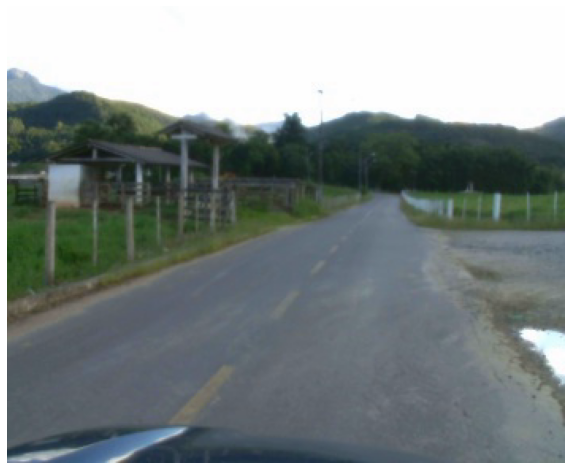

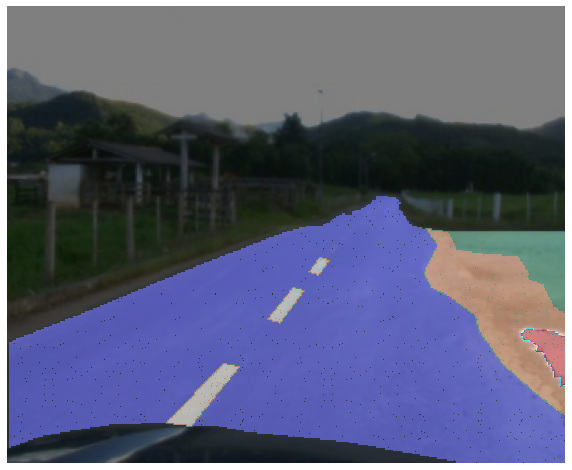

In [17]:
img_f = image_file_name[2]
img = PILImage.create(img_f)
mask = PILMask.create(get_y_fn(img_f))
img.show(figsize=(10,10))
ax = img.show(figsize=(10,10))
mask.show(ctx=ax, figsize=(10,10), cmap=ListedColormap(cmap), vmax=len(cmap))

In [18]:
src_size = np.array(mask.shape)
src_size

array([288, 352])

## 3. First Step - Without weights

---



### 3.1. First step Datasets

---



In [19]:
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

GPU RAM Free: 15106MB | Used: 3MB | Util   0% | Total 15109MB


In [20]:
size = PILMask.create(get_y_fn(img_f)).shape
print(size)

(288, 352)


In [21]:
data_block = DataBlock(blocks=(ImageBlock, MaskBlock(codes = codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=11),
    get_y=get_y_fn,
    )

In [22]:
# data_block.summary(image_path,show_batch=True)

In [23]:
datasets = data_block.datasets(image_path)

In [24]:
print(datasets.train[0])
print(datasets.valid[0])
print(len(datasets.train))
print(len(datasets.valid))

(PILImage mode=RGB size=352x288, PILMask mode=L size=352x288)
(PILImage mode=RGB size=352x288, PILMask mode=L size=352x288)
586
146


In [25]:
dataloaders = data_block.dataloaders(image_path, bs=batch_size, num_workers=4)

In [26]:
dataloaders.splits

(#2) [[145, 534, 674, 90, 598, 601, 57, 437, 305, 473, 484, 299, 381, 524, 481, 419, 250, 653, 379, 19, 707, 479, 240, 708, 316, 161, 435, 154, 502, 82, 162, 289, 13, 69, 344, 478, 93, 623, 357, 428, 151, 25, 221, 522, 165, 389, 270, 628, 261, 506, 694, 319, 229, 75, 618, 576, 26, 556, 460, 310, 465, 672, 50, 196, 104, 528, 345, 73, 516, 248, 353, 678, 364, 339, 695, 459, 626, 523, 117, 215, 403, 511, 180, 89, 469, 567, 171, 343, 293, 564, 637, 417, 430, 701, 16, 110, 334, 201, 562, 382, 130, 552, 529, 688, 352, 445, 491, 317, 641, 615, 134, 311, 508, 220, 719, 46, 713, 525, 401, 30, 700, 390, 369, 696, 203, 4, 236, 380, 354, 412, 175, 458, 644, 346, 690, 9, 76, 291, 405, 313, 546, 79, 42, 361, 515, 553, 51, 673, 398, 211, 608, 323, 227, 410, 676, 255, 183, 78, 499, 657, 386, 95, 636, 457, 451, 659, 178, 186, 157, 579, 728, 181, 168, 453, 611, 191, 517, 139, 277, 620, 448, 307, 583, 418, 547, 643, 394, 520, 668, 68, 603, 108, 133, 450, 302, 413, 335, 87, 243, 80, 338, 591, 280, 504, 14

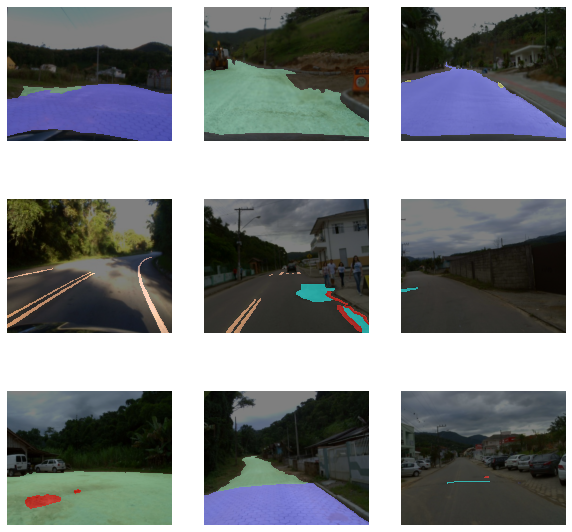

In [27]:
# start = time.time()
dataloaders.show_batch(figsize=(10,10), cmap=ListedColormap(cmap), vmax=len(cmap))
# dataloaders.show_batch(figsize=(10,10))
# end = time.time()
# print(end-start)

### 3.2. First step Model

---



In [28]:
used_model = LiteHRNet(_C)

600


In [29]:
name2id = {v:k for k,v in enumerate(codes)}
name2id

{'background': 0,
 'catsEye': 6,
 'cracks': 12,
 'manholeCover': 8,
 'patchs': 9,
 'pothole': 11,
 'roadAsphalt': 1,
 'roadMarking': 4,
 'roadPaved': 2,
 'roadUnpaved': 3,
 'speedBump': 5,
 'stormDrain': 7,
 'waterPuddle': 10}

In [30]:
# check what is supp
# void_code = name2id['manholeCover']
# def acc_rtk(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()


def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [31]:
metrics=acc_rtk
wd=1e-2

In [32]:
# learn = unet_learner(dataloaders, used_model, metrics=metrics, wd=wd, pretrained=False,
#                      loss_func=CrossEntropyLossFlat(axis=1), path=model_path, model_dir='fastai-training',y_range=(0,1))

In [35]:
learn = Learner(dataloaders, used_model, metrics=metrics, wd=wd,
                     loss_func=CrossEntropyLossFlat(axis=1), path=model_path, model_dir=model_dir)

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=0.0014454397605732083)

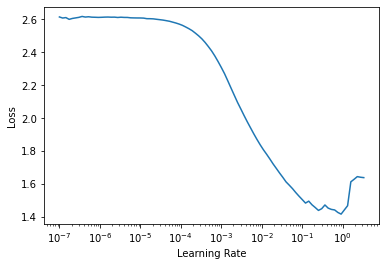

In [36]:
learn.lr_find()

In [37]:
lr = 3e-2
print(slice(lr))

slice(None, 0.03, None)


In [38]:
cbs = [SaveModelCallback(every_epoch=True, monitor='acc_rtk', fname='model_test')]

In [39]:
# fit_one_cycle aceita wd. wd ja nao foi escolhido no learn? SIM, usa o wd do learn se wd=None
learn.fit_one_cycle(5, lr_max=lr, pct_start=0.4, cbs=cbs)

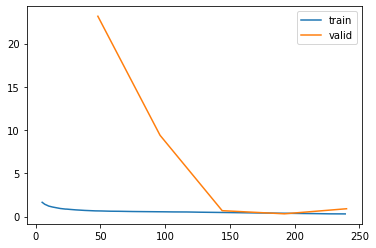

In [40]:
# por algum motivo tem q rodar isso antes de rodar o show_results, caso contrário o gráfico nao funciona
learn.recorder.plot_loss()

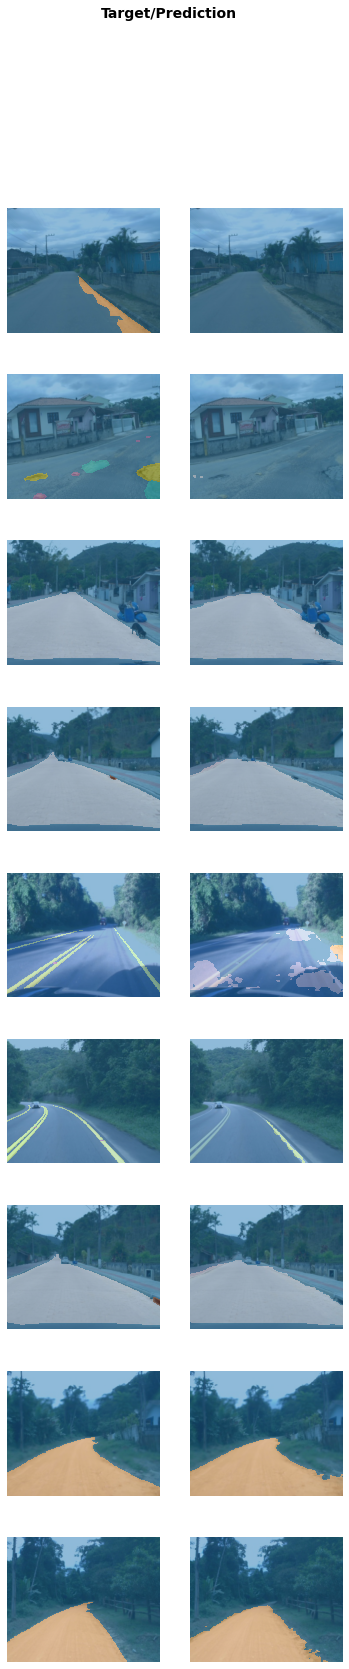

In [41]:
learn.show_results(ds_idx=0)

In [42]:
# RODAR CASO TENHA TRAVADO - na vdd unfreeze vai descongelar todas os parametros, se a rede ja comeca com todos os parametros descongelados
# isso nao faz diferenca
learn.unfreeze()

In [43]:
learn.save('first-stage-first-step');

In [44]:
learn.load('first-stage-first-step');

In [ ]:
# learn.show_results()

### 3.3. Interpret

---



In [45]:
interp = SegmentationInterpretation.from_learner(learn)

In [46]:
top_losses, top_idxs = interp.top_losses()
len(top_losses)

146

(array([145.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.7032573e-02, 4.9575334e+00, 9.8880339e+00, 1.4818535e+01,
        1.9749035e+01, 2.4679537e+01, 2.9610037e+01, 3.4540539e+01,
        3.9471039e+01, 4.4401539e+01, 4.9332039e+01, 5.4262539e+01,
        5.9193043e+01, 6.4123543e+01, 6.9054039e+01, 7.3984543e+01,
        7.8915047e+01, 8.3845543e+01, 8.8776047e+01, 9.3706543e+01,
        9.8637047e+01], dtype=float32),
 <a list of 20 Patch objects>)

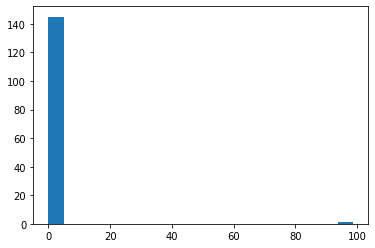

In [47]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

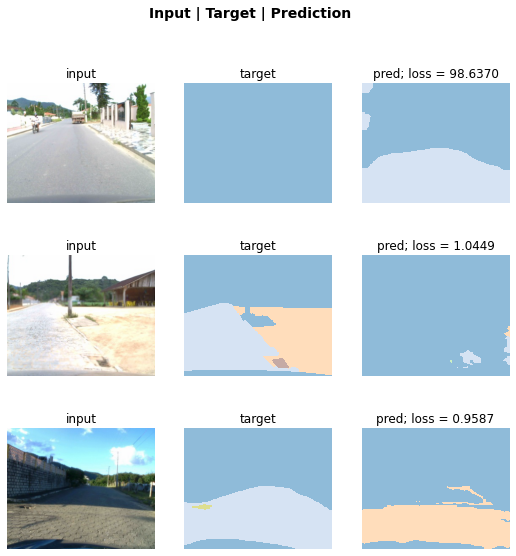

In [51]:
# top loss idxs of images
interp.plot_top_losses(3)
# interp.plot_top_losses(2, cmap=ListedColormap(cmap), vmax=len(cmap))

### 3.4. Confusion Matrix

---



In [52]:
def pixel_acc(input, target):
    target = target.squeeze(1)
    pred = input.argmax(dim=1)
    print(target.shape)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [53]:
# learn.validate(metrics=pixel_acc)

In [54]:
from sklearn.metrics import confusion_matrix
it = 0
# print(type(dataloaders.valid_ds[0][0]))
# print(len(dataloaders.valid_ds))
print(len(dataloaders.valid_ds))
l = len(dataloaders.valid_ds)
confusion = np.zeros((num_classes,num_classes))

for image, mask in dataloaders.valid_ds:
  # image = dataloaders.valid_ds[0][0]
  # mask = dataloaders.valid_ds[0][1]
  # image = image2tensor( image  )
  true_class = image2tensor( mask  )
  pred_class, pred, probs = learn.predict(image)

  # print(image)
  # print(mask)
  # print(image.shape)
  # print(mask.shape)

  # print(pred_class.shape)
  # # print(pred_class)
  # pred_img = PILImage.create(pred_class)
  # print(pred)
  # ax = pred_img.show(figsize=(10,10))
  # pred_img.show(ctx=ax, figsize=(10,10), cmap=ListedColormap(cmap), vmax=len(cmap))
  # print(true_class.shape)
  print(it)
  # print(type(true_class[0]))
  # print(type(pred_class))
  # print(confusion_matrix(true_class[0], pred_class))
  # break
  for i in range(img_height):
    for j in range(img_width):
      confusion[true_class[0][i][j]][pred_class[i][j]] += 1

  it+=1
  # break
# print(j)
# print(image2tensor( dataloaders.valid_ds[0][0]  ).shape    )
# print(dataloaders.valid.get_idxs())
# print(dataloaders.valid.sample())

# print(len(dataloaders.valid))
# print(dataloaders.splits)
# print(len(dataloaders.splits))
# print(len(dataloaders.splits[0]))
# print(len(dataloaders.splits[1]))
# for i in iter(dataloaders.valid):
#   print(type(i))
#   # print(i)
#   j+=1
#   break

# print(j)

146


0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


TensorMask([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])


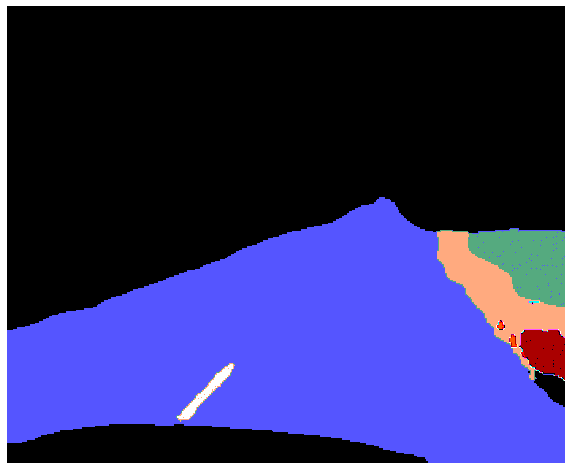

In [ ]:
pred_class, pred, probs = learn.predict(img_f)
print(pred_class)
# # print(pred_class)
pred_img = PILImage.create(pred_class)
# print(pred)
ax = pred_img.show(figsize=(10,10))
pred_img.show(ctx=ax, figsize=(10,10), cmap=ListedColormap(cmap), vmax=len(cmap))
# pred_img.shape

In [58]:
confusion

array([[9.640271e+06, 8.520200e+04, 4.614500e+04, 8.675500e+04,
        1.483000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [7.687400e+04, 1.583356e+06, 9.710500e+04, 1.757300e+04,
        2.059000e+03, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [6.514700e+04, 2.280920e+05, 1.133586e+06, 8.432500e+04,
        1.460000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [5.988100e+04, 3.301800e+04, 1.288700e+04, 1.299301e+06,
        3.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00],
       [7.659000e+03, 9.003900e+04, 2.059000e+03, 2.058000e+03,
        1.020000e+04, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.00

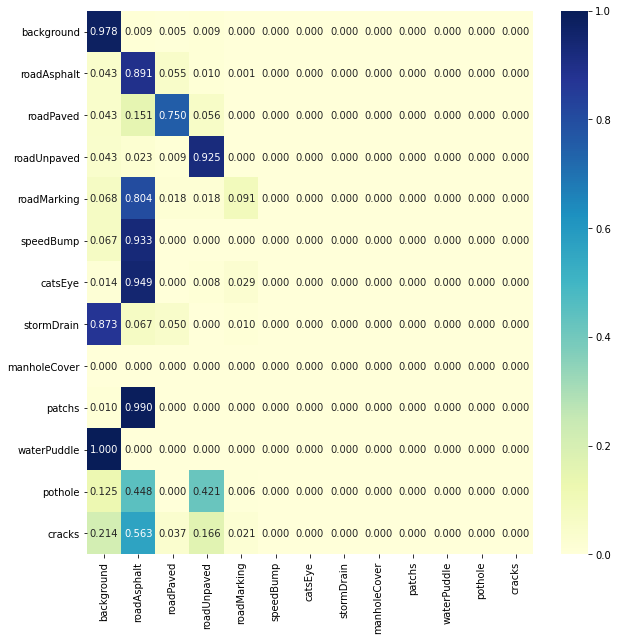

In [57]:
import seaborn as sns

def plot_conf_matrix(conf_matrix):
  sns.color_palette("Blues", as_cmap=True)

  conf_matrix_norm = np.zeros(conf_matrix.shape)
  for i in range(num_classes):
    if sum(conf_matrix[i]) !=0:
      conf_matrix_norm[i] = conf_matrix[i].copy()/sum(conf_matrix[i])
    else:
      conf_matrix_norm[i] = 0

  conf_matrix_pd = pd.DataFrame(conf_matrix_norm, index=codes, columns=codes)

  fig, ax = plt.subplots(figsize=(10,10))
  sns_plot = sns.heatmap(conf_matrix_pd, annot=True, ax=ax, cmap="YlGnBu", fmt=".3f")

plot_conf_matrix(np.asarray(confusion))

### 3.5. First model continuation

---



In [59]:
learn.unfreeze()

SuggestedLRs(lr_min=8.31763736641733e-07, lr_steep=1.9054607491852948e-06)

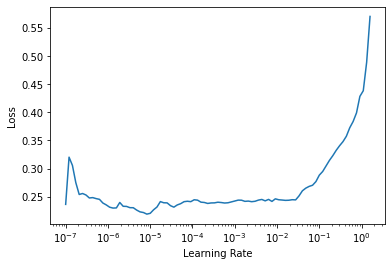

In [60]:
learn.lr_find()

In [61]:
lr = 1e-5

In [62]:
learn.fit_one_cycle(30, lr_max=lr, pct_start=0.4, cbs=[SaveModelCallback(every_epoch=True, monitor='acc_rtk', fname='model_test2')])

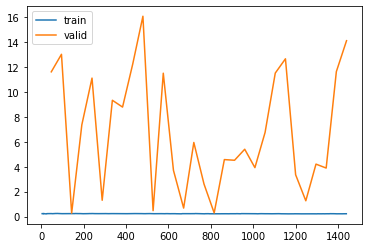

In [63]:
learn.recorder.plot_loss()

In [64]:
learn.save('first-stage-second-step');

In [65]:
learn.load('first-stage-second-step');

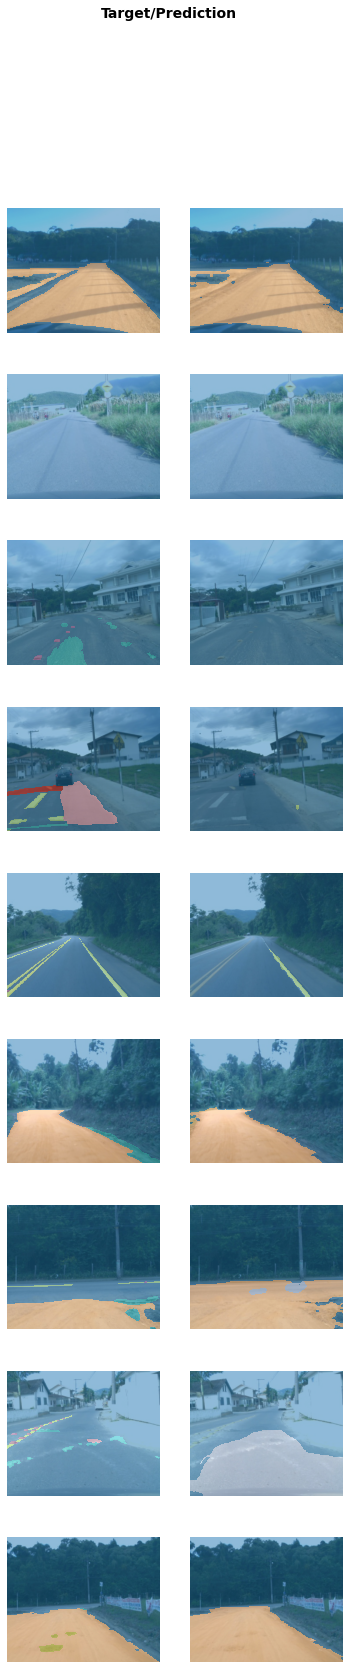

In [70]:
learn.show_results(ds_idx=1)

### 3.6. Confusion Matrix

---



In [71]:
it = 0
print(len(dataloaders.valid_ds))
confusion = np.zeros((num_classes,num_classes))

for image, mask in dataloaders.valid_ds:
  true_class = image2tensor( mask  )
  pred_class, pred, probs = learn.predict(image)
  print(it)
  for i in range(img_height):
    for j in range(img_width):
      confusion[true_class[0][i][j]][pred_class[i][j]] += 1
  it+=1

146


0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


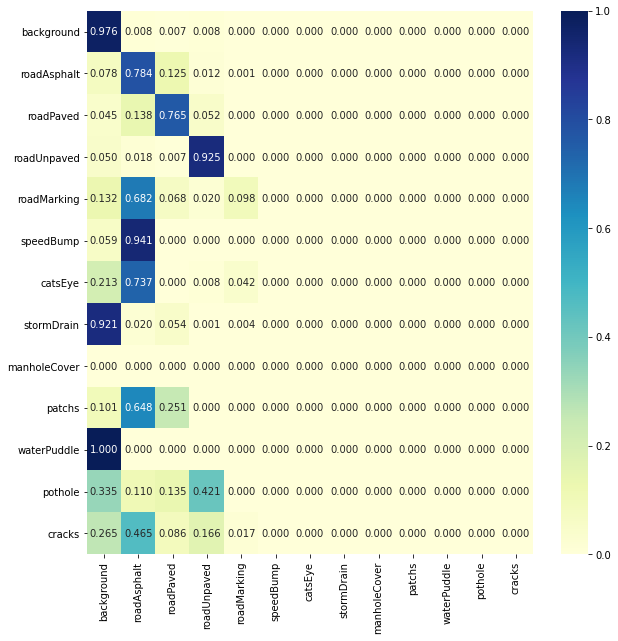

In [72]:
plot_conf_matrix(confusion)

### 3.7. Interpret

---



In [73]:
interp = SegmentationInterpretation.from_learner(learn)

In [74]:
top_losses, top_idxs = interp.top_losses()
len(top_losses)

146

(array([142.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   3.]),
 array([2.3138948e-02, 2.6529842e+01, 5.3036549e+01, 7.9543251e+01,
        1.0604996e+02, 1.3255666e+02, 1.5906337e+02, 1.8557007e+02,
        2.1207677e+02, 2.3858348e+02, 2.6509018e+02, 2.9159689e+02,
        3.1810358e+02, 3.4461029e+02, 3.7111700e+02, 3.9762372e+02,
        4.2413040e+02, 4.5063712e+02, 4.7714383e+02, 5.0365051e+02,
        5.3015723e+02], dtype=float32),
 <a list of 20 Patch objects>)

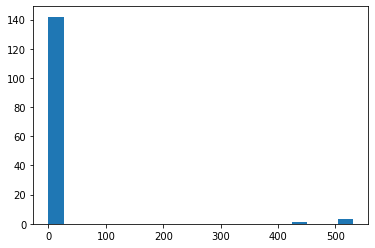

In [75]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

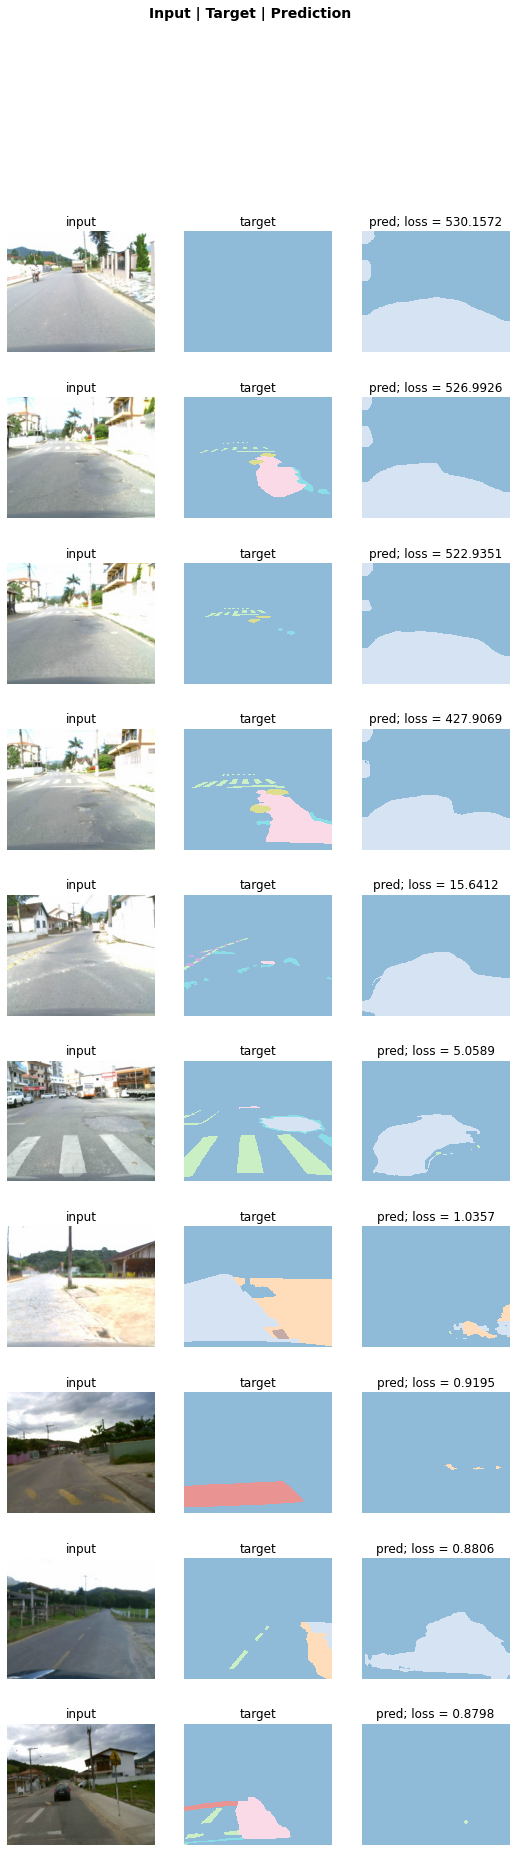

In [76]:
# top loss idxs of images
interp.plot_top_losses(10)

### 3.8. Saving

---



In [ ]:
# learn.save('stage-2_dsufsc1')

In [ ]:
# learn.export('/content/gdrive/My Drive/Datasets Caminho/DATASET - UFSC/export_dsufsc1.pkl')

In [ ]:
# data=None
# learn=None
# gc.collect()

53986

## 4. Second Step - With weights

---



### 4.2. Second step Model

---



In [79]:
used_model = LiteHRNet(_C)
name2id = {v:k for k,v in enumerate(codes)}

# check this
# void_code = name2id['manholeCover']

# def acc_rtk(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

# check what is supp
# void_code = name2id['manholeCover']
# def acc_rtk(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()


def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

600


In [80]:
metrics=acc_rtk
wd=1e-2

In [81]:
balanced_loss = CrossEntropyLossFlat(axis=1, weight=torch.tensor([1.0,5.0,6.0,7.0,75.0,1000.0,3100.0,3300.0,0.0,270.0,2200.0,1000.0,180.0]).cuda())

learn = Learner(dataloaders, used_model, metrics=metrics, wd=wd,
                     loss_func=balanced_loss, path=model_path, model_dir=model_dir)

In [82]:
learn.load('first-stage-second-step');

In [83]:
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

GPU RAM Free: 10185MB | Used: 4924MB | Util  33% | Total 15109MB


SuggestedLRs(lr_min=0.05248074531555176, lr_steep=7.585775847473997e-07)

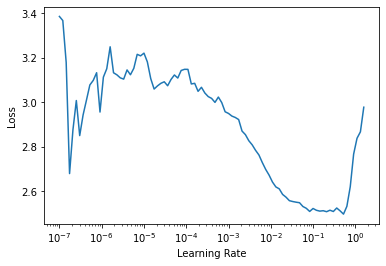

In [84]:
learn.lr_find()

In [85]:
lr=1e-2

In [86]:
# check frozen layers
for name, module in learn.model.named_parameters():
  print(name)
  print(module.requires_grad)
    # module.requires_grad_(False)

stem.conv1.weight
True
stem.batchnorm1.weight
True
stem.batchnorm1.bias
True
stem.branch1.0.weight
True
stem.branch1.1.weight
True
stem.branch1.1.bias
True
stem.branch1.2.weight
True
stem.branch1.3.weight
True
stem.branch1.3.bias
True
stem.expand_conv.0.weight
True
stem.expand_conv.1.weight
True
stem.expand_conv.1.bias
True
stem.depthwise_conv.0.weight
True
stem.depthwise_conv.1.weight
True
stem.depthwise_conv.1.bias
True
stem.linear_conv.0.weight
True
stem.linear_conv.1.weight
True
stem.linear_conv.1.bias
True
transition0.0.0.weight
True
transition0.0.1.weight
True
transition0.0.1.bias
True
transition0.0.2.weight
True
transition0.0.3.weight
True
transition0.0.3.bias
True
transition0.1.0.0.weight
True
transition0.1.0.1.weight
True
transition0.1.0.1.bias
True
transition0.1.0.2.weight
True
transition0.1.0.3.weight
True
transition0.1.0.3.bias
True
stage0.0.layers.0.cross_resolution_weighting.conv1.weight
True
stage0.0.layers.0.cross_resolution_weighting.batchnorm1.weight
True
stage0.0.lay

In [87]:
# freeze weights

for name, module in learn.model.named_children():
  print(name)

print('=======')

for name, module in learn.model.named_children():
  if(name in ['stem', 'transition0', 'stage0', 'transition1', 'stage1', ]):
    print(name)
    module.requires_grad_(False)

stem
transition0
stage0
transition1
stage1
transition2
stage2
last_layer
stem
transition0
stage0
transition1
stage1


In [88]:
# check frozen layers
for name, module in learn.model.named_parameters():
  print(name)
  print(module.requires_grad)
    # module.requires_grad_(False)

stem.conv1.weight
False
stem.batchnorm1.weight
False
stem.batchnorm1.bias
False
stem.branch1.0.weight
False
stem.branch1.1.weight
False
stem.branch1.1.bias
False
stem.branch1.2.weight
False
stem.branch1.3.weight
False
stem.branch1.3.bias
False
stem.expand_conv.0.weight
False
stem.expand_conv.1.weight
False
stem.expand_conv.1.bias
False
stem.depthwise_conv.0.weight
False
stem.depthwise_conv.1.weight
False
stem.depthwise_conv.1.bias
False
stem.linear_conv.0.weight
False
stem.linear_conv.1.weight
False
stem.linear_conv.1.bias
False
transition0.0.0.weight
False
transition0.0.1.weight
False
transition0.0.1.bias
False
transition0.0.2.weight
False
transition0.0.3.weight
False
transition0.0.3.bias
False
transition0.1.0.0.weight
False
transition0.1.0.1.weight
False
transition0.1.0.1.bias
False
transition0.1.0.2.weight
False
transition0.1.0.3.weight
False
transition0.1.0.3.bias
False
stage0.0.layers.0.cross_resolution_weighting.conv1.weight
False
stage0.0.layers.0.cross_resolution_weighting.batc

In [89]:
# fit_one_cycle aceita wd. wd ja nao foi escolhido no learn? SIM, usa o wd do learn se wd=None
learn.fit_one_cycle(5, lr_max=lr, pct_start=0.4, cbs= [SaveModelCallback(every_epoch=True, monitor='acc_rtk', fname='model_test3')])

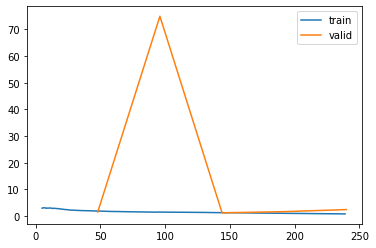

In [90]:
# por algum motivo tem q rodar isso antes de rodar o show_results, caso contrário o gráfico nao funciona
learn.recorder.plot_loss()

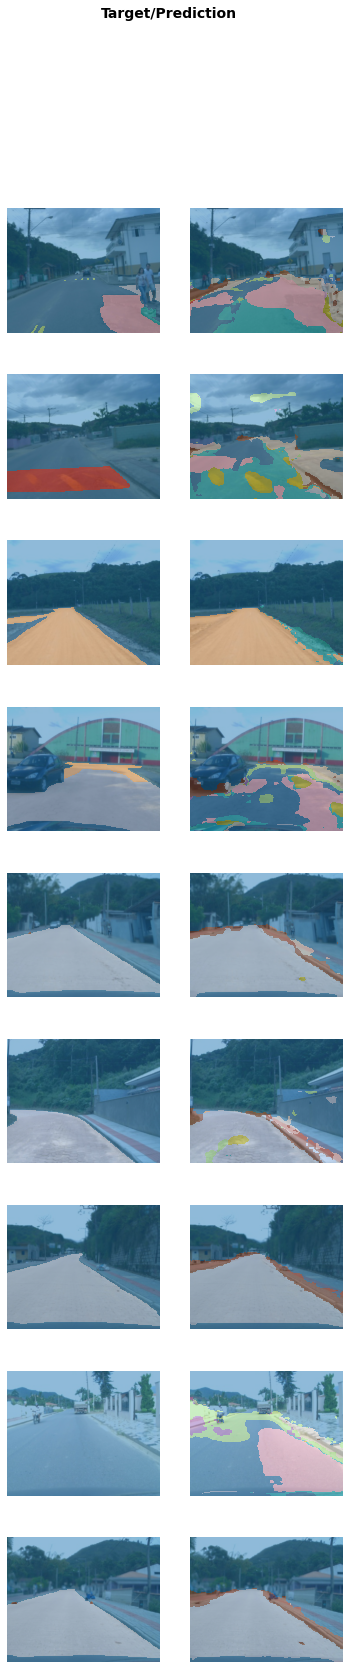

In [92]:
learn.show_results(ds_idx=1)

In [93]:
learn.unfreeze()
# check frozen layers
for name, module in learn.model.named_parameters():
  print(name)
  print(module.requires_grad)
    # module.requires_grad_(False)

stem.conv1.weight
True
stem.batchnorm1.weight
True
stem.batchnorm1.bias
True
stem.branch1.0.weight
True
stem.branch1.1.weight
True
stem.branch1.1.bias
True
stem.branch1.2.weight
True
stem.branch1.3.weight
True
stem.branch1.3.bias
True
stem.expand_conv.0.weight
True
stem.expand_conv.1.weight
True
stem.expand_conv.1.bias
True
stem.depthwise_conv.0.weight
True
stem.depthwise_conv.1.weight
True
stem.depthwise_conv.1.bias
True
stem.linear_conv.0.weight
True
stem.linear_conv.1.weight
True
stem.linear_conv.1.bias
True
transition0.0.0.weight
True
transition0.0.1.weight
True
transition0.0.1.bias
True
transition0.0.2.weight
True
transition0.0.3.weight
True
transition0.0.3.bias
True
transition0.1.0.0.weight
True
transition0.1.0.1.weight
True
transition0.1.0.1.bias
True
transition0.1.0.2.weight
True
transition0.1.0.3.weight
True
transition0.1.0.3.bias
True
stage0.0.layers.0.cross_resolution_weighting.conv1.weight
True
stage0.0.layers.0.cross_resolution_weighting.batchnorm1.weight
True
stage0.0.lay

In [94]:
learn.save('second-stage-first-step');
learn.load('second-stage-first-step');

In [95]:
# learn.show_results()

### 4.3. Interpret

---



In [96]:
interp = SegmentationInterpretation.from_learner(learn)

In [97]:
top_losses, top_idxs = interp.top_losses()
len(top_losses)

146

(array([135.,   3.,   3.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.]),
 array([2.6316109e-01, 2.6508884e+01, 5.2754604e+01, 7.9000328e+01,
        1.0524605e+02, 1.3149178e+02, 1.5773750e+02, 1.8398322e+02,
        2.1022894e+02, 2.3647467e+02, 2.6272040e+02, 2.8896609e+02,
        3.1521182e+02, 3.4145755e+02, 3.6770328e+02, 3.9394901e+02,
        4.2019473e+02, 4.4644043e+02, 4.7268616e+02, 4.9893188e+02,
        5.2517761e+02], dtype=float32),
 <a list of 20 Patch objects>)

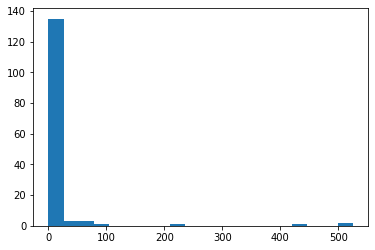

In [98]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

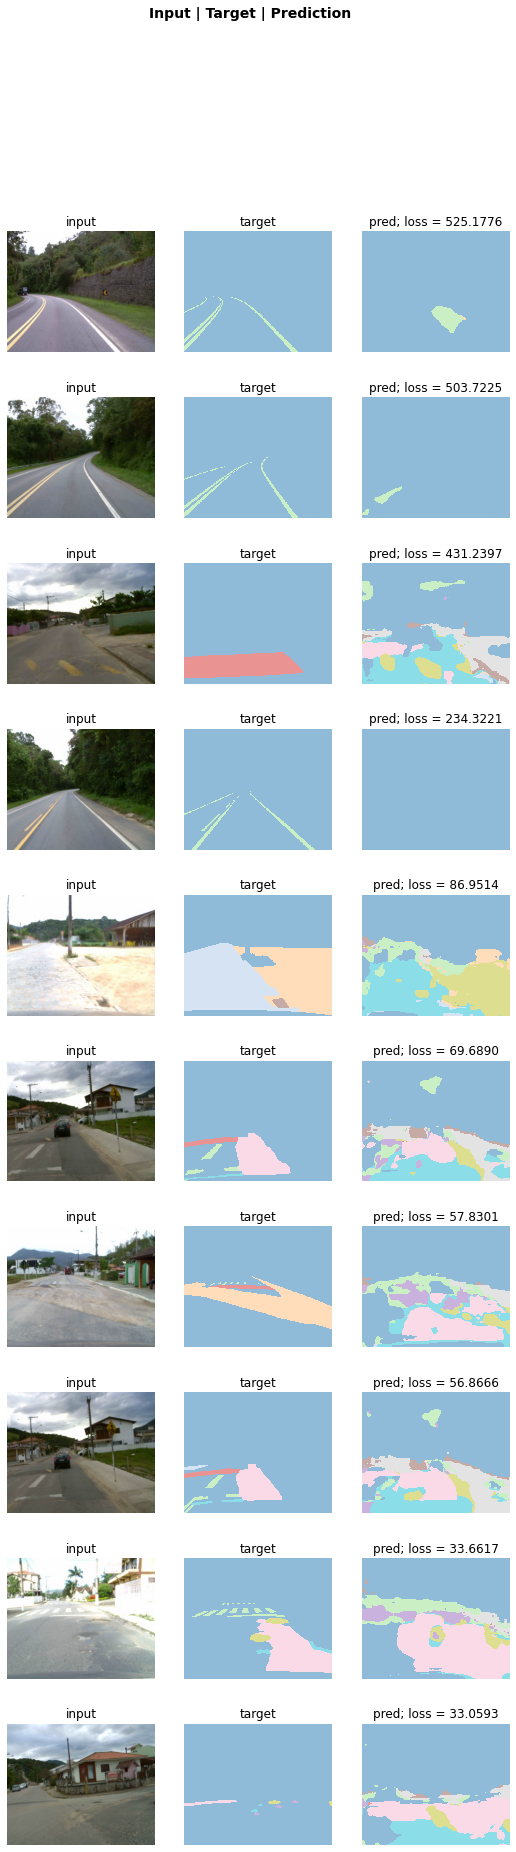

In [99]:
# top loss idxs of images
interp.plot_top_losses(10)

### 4.4. Confusion Matrix

---



In [ ]:
it = 0
print(len(dataloaders.valid_ds))
confusion = np.zeros((num_classes,num_classes))

for image, mask in dataloaders.valid_ds:
  true_class = image2tensor( mask  )
  pred_class, pred, probs = learn.predict(image)
  print(it)
  for i in range(img_height):
    for j in range(img_width):
      confusion[true_class[0][i][j]][pred_class[i][j]] += 1
  it+=1

146


0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


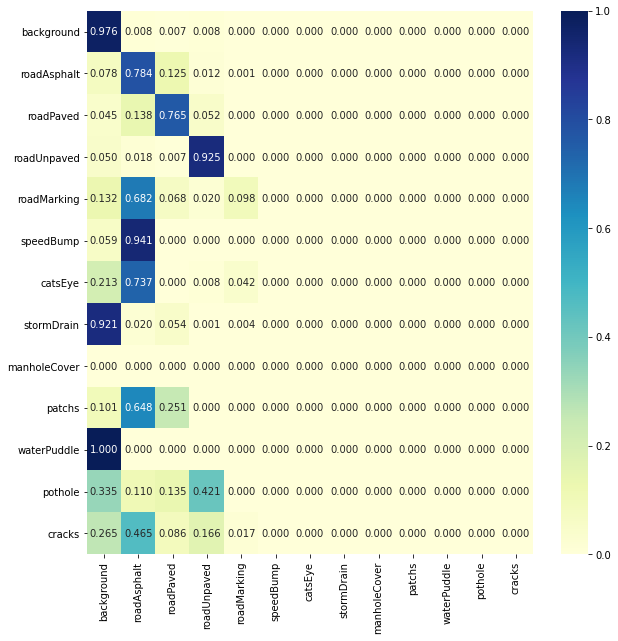

In [ ]:
plot_conf_matrix(confusion)

### 4.5. Second model continuation

---



In [100]:
learn.unfreeze()

SuggestedLRs(lr_min=0.0007585775572806596, lr_steep=2.2908675418875646e-06)

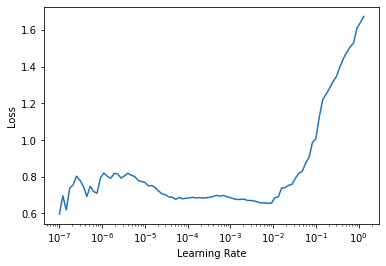

In [101]:
learn.lr_find()

In [102]:
lr = 1e-3

In [ ]:
learn.fit_one_cycle(30, lr_max=lr, pct_start=0.4, cbs=[SaveModelCallback(every_epoch=True, monitor='acc_rtk', fname='model_test4')])

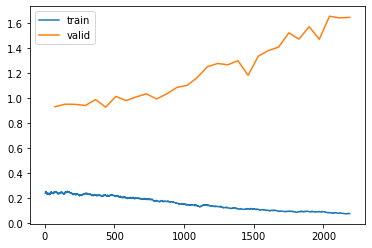

In [99]:
learn.recorder.plot_loss()

In [100]:
learn.save('second-stage-second-step');
learn.load('second-stage-second-step');

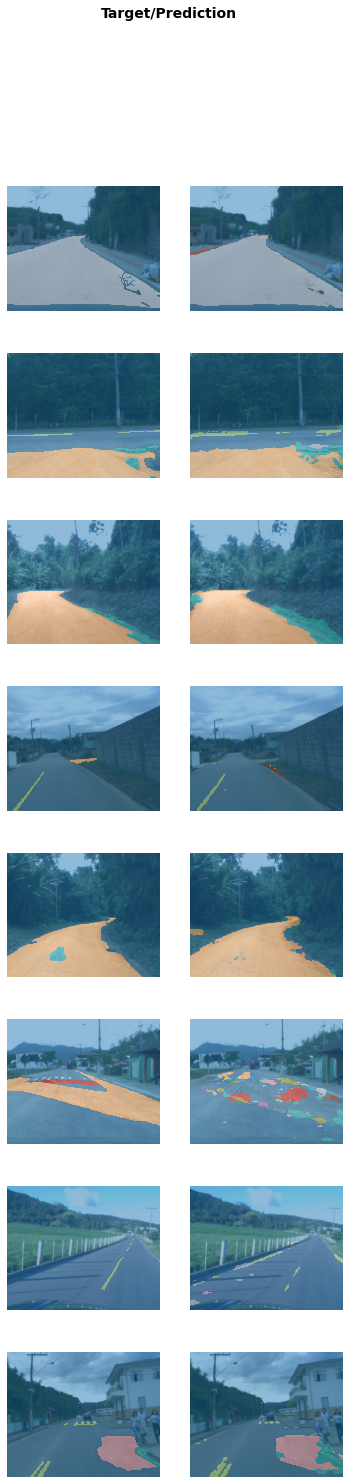

In [106]:
learn.show_results(ds_idx=1)

### 4.6. Confusion Matrix

---



In [ ]:
it = 0
print(len(dataloaders.valid_ds))
confusion = np.zeros((num_classes,num_classes))

for image, mask in dataloaders.valid_ds:
  true_class = image2tensor( mask  )
  pred_class, pred, probs = learn.predict(image)
  print(it)
  for i in range(img_height):
    for j in range(img_width):
      confusion[true_class[0][i][j]][pred_class[i][j]] += 1
  it+=1

146


0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


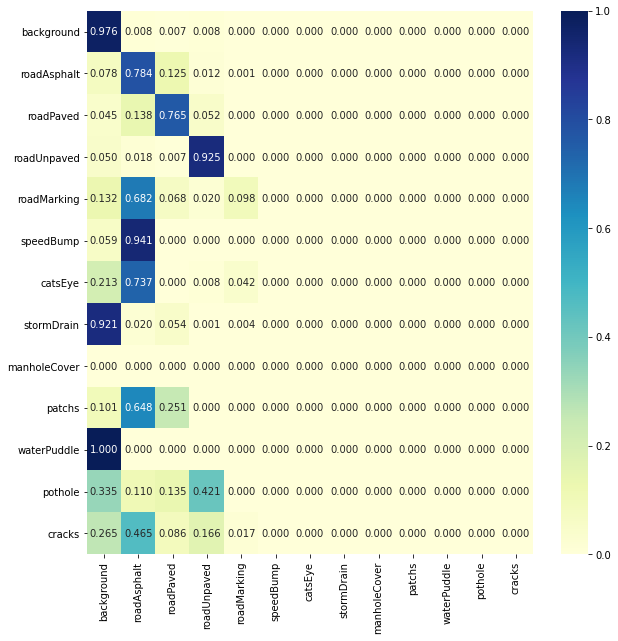

In [ ]:
plot_conf_matrix(confusion)

### 4.7. Interpret

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
top_losses, top_idxs = interp.top_losses()
len(top_losses)

146

(array([18., 31., 23., 15.,  4.,  5.,  8.,  8.,  4.,  4.,  7.,  4.,  3.,
         1.,  0.,  3.,  2.,  2.,  0.,  4.]),
 array([0.05534546, 0.10569243, 0.1560394 , 0.20638639, 0.25673336,
        0.30708033, 0.3574273 , 0.40777427, 0.45812124, 0.5084682 ,
        0.5588152 , 0.60916215, 0.6595091 , 0.70985615, 0.7602031 ,
        0.8105501 , 0.86089706, 0.91124403, 0.961591  , 1.011938  ,
        1.062285  ], dtype=float32),
 <a list of 20 Patch objects>)

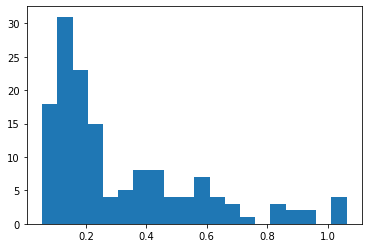

In [ ]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

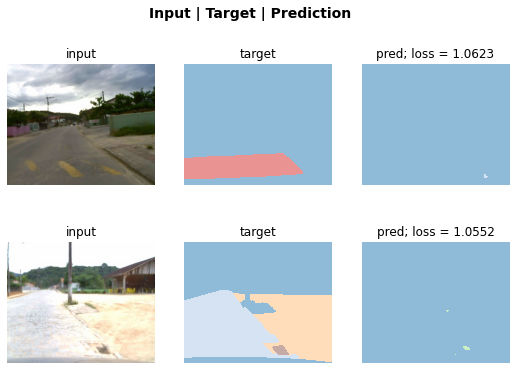

In [ ]:
# top loss idxs of images
interp.plot_top_losses(2)

### 4.8. Saving

---



In [ ]:
# learn.save('stage-2-weights_dsufsc1')
# #mudar nomes de arquivos
# learn.export('/content/gdrive/My Drive/Datasets Caminho/DATASET - UFSC/export_dsufsc_v10_100epochs.pkl')

## 5. Using a saved model to Predict

---



In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11405MB of GPU RAM free


In [ ]:
src = (SegmentationItemList.from_folder(path_output_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34)

In [ ]:
learn.load('stage-2-weights_dsufsc1');

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (18, 13, 13))

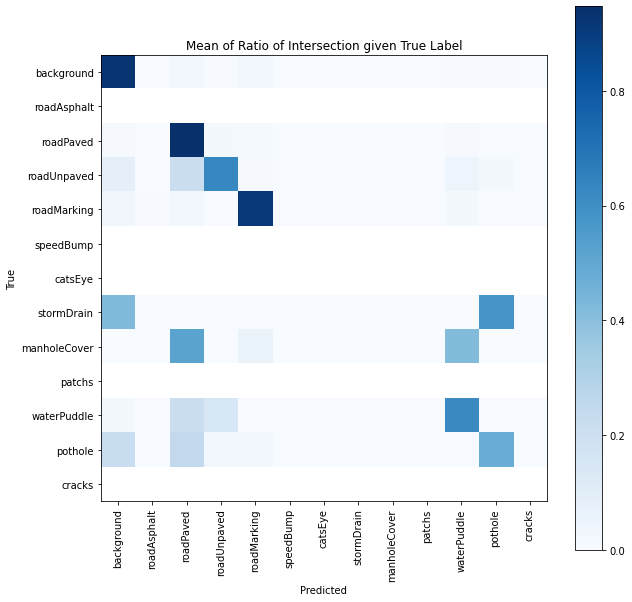

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

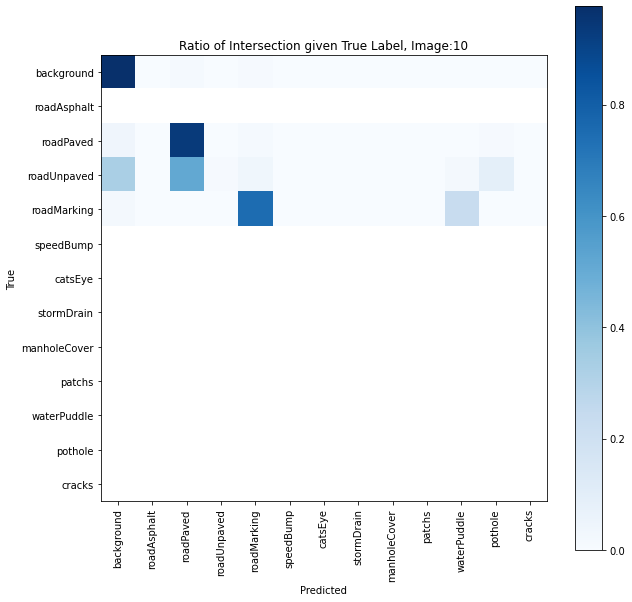

In [ ]:
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

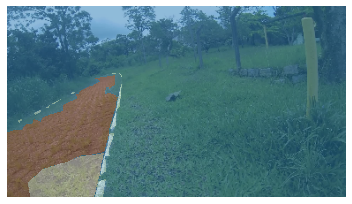

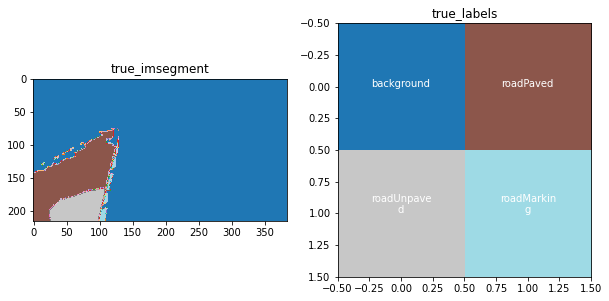

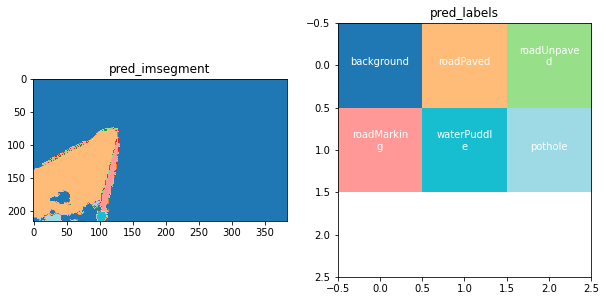

In [ ]:
# show xyz
interp.show_xyz(i)

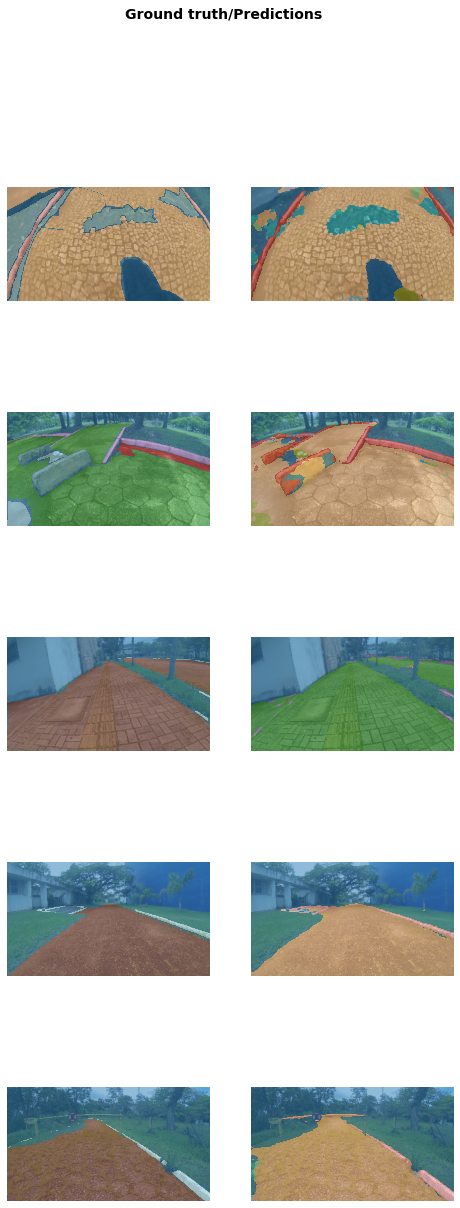

In [ ]:
learn.show_results()

## 6. Saving the Results

---



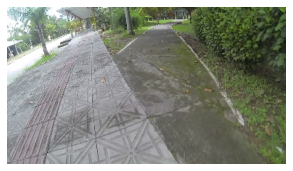

In [ ]:
img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
import time
start = time.time()
prediction = learn.predict(img)
print(time.time() - start)

2.2406399250030518


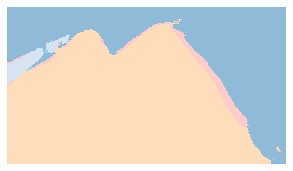

In [ ]:
prediction[0].show(figsize=(5,5))

In [ ]:
results_save = 'results'
path_rst = path/results_save
path_rst.mkdir(exist_ok=True)

In [ ]:
def save_preds(names):
    i=0
    #names = dl.dataset.items
    
    for b in names:
        img_s = fnames[i]
        img_toSave = open_image(img_s)
        img_split = f'{img_s}'
        #sempre checar o esse numero aqui em baixo para ver se está correto com o path!! 
        img_split = img_split[97:]
        predictionSave = learn.predict(img_toSave)
        predictionSave[0].save(path_rst/img_split) #Save Image
        i += 1
        print(i)

In [ ]:
save_preds(fnames)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194


## 7. Coloring the Results

---




In [ ]:
import os
import glob
import base64
import cv2 as cv
cv.__version__

'4.1.2'

In [ ]:
colored_results = 'results_color'
path_crst = path/colored_results
path_crst.mkdir(exist_ok=True)

In [ ]:
%load_ext cython

In [ ]:
%%cython -a
import cython
cimport numpy
import cv2 as cv
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
#def colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
cpdef numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
  # set the variable extension types
  cdef int x, y, width, height, b, g, r

  #frame = cv.imdecode(np.frombuffer(byteframe, np.uint8), -1)

  # grab the image dimensions
  width = 216
  height = 384
    
  # loop over the image, pixel by pixel
  for x in range(width):
    for y in range(height):
      b, g, r = frame[x, y]
      if (b, g, r) == (0,0,0): #background
        frame[x, y] = (0,0,0)
      elif (b, g, r) == (1,1,1): #roadAsphalt
        frame[x, y] = (85,85,255)
      elif (b, g, r) == (2,2,2): #roadPaved
        frame[x, y] = (85,170,127)
      elif (b, g, r) == (3,3,3): #roadUnpaved
        frame[x, y] = (255,170,127) 
      elif (b, g, r) == (4,4,4): #roadMarking
        frame[x, y] = (255,255,255) 
      elif (b, g, r) == (5,5,5): #speedBump
        frame[x, y] = (255,85,255)
      elif (b, g, r) == (6,6,6): #catsEye
        frame[x, y] = (255,255,127)          
      elif (b, g, r) == (7,7,7): #stormDrain
        frame[x, y] = (170,0,127) 
      elif (b, g, r) == (8,8,8): #manholeCover
        frame[x, y] = (0,255,255) 
      elif (b, g, r) == (9,9,9): #patchs
        frame[x, y] = (0,0,127) 
      elif (b, g, r) == (10,10,10): #waterPuddle
        frame[x, y] = (170,0,0)
      elif (b, g, r) == (11,11,11): #pothole
        frame[x, y] = (255,0,0)
      elif (b, g, r) == (12,12,12): #cracks
        frame[x, y] = (255,85,0)
 
  frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
  
  # return the colored image
  return frame

In [ ]:
import timeit
# Count variables
fqtd = 0

filenames = [img for img in glob.glob(str(path_rst/"*.png"))]

filenames.sort() # ADD THIS LINE

for img in filenames:
  frame = cv.imread(img)

  #%timeit colorfull_fast(frame)
  
  frame = colorfull_fast(frame)
  name = "%09d.png"%fqtd
  cv.imwrite(os.path.join(path_crst, name), frame)

  fqtd += 1
  print(fqtd)

print("Done!")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
Done!
